### **Install and Import Libraries**

In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
from skimage import io
from google.colab.patches import cv2_imshow
from glob import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.optim as optim

from tqdm import tqdm
from bayes_opt import BayesianOptimization

In [ ]:
# Matplotlib's PyPlot to show an image stored in a pytorch tensor 
def imshow(inp, title=None):
  """
    Parameters: 
      * inp: the image that we want to show (it needs to have 3 channels, numpy does not show grayscale images)
      * title (optional): the title to show with the image
  """
  inp = inp.numpy().transpose((1, 2, 0)) # Convert from HxWxC format of tensor to CxHxW format of numpy

  plt.imshow(inp) # Show the image 
  if title is not None:
      plt.title(title) # Add a title if provided
  plt.pause(0.001)  # pause a bit so that plots are updated

**DICE Binary Cross entrpy Combination Loss**

In [ ]:
class LossDICEBCE(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(LossDICEBCE, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
    
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        
        inputs = torch.sigmoid(inputs) 
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        # Both losses combined 
        DiceBCE = BCE + dice_loss
        
        return DiceBCE

**Jaccard/Intersection over Union (IoU) Loss**

In [ ]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

**Evaluation Metrics**

In [ ]:
# Jaccard Score
def jaccard2(im1, im2, empty_score=1.0):
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    union = np.logical_or(im1, im2)

    return intersection.sum() / float(union.sum())

In [ ]:
# Dice Score
def get_dice(inputs, targets, smooth = 0.00004):
  inputs = torch.sigmoid(inputs)       
        
  inputs = inputs.view(-1)
  targets = targets.view(-1)
        
  intersection = (inputs * targets).sum()                            
  dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
  return dice

In [ ]:
# Average Jaccard Score for all images in a dataloader
def check_js(loader, model, threshold= 0.5, device="cuda"):

  model.eval() 
  j = 0;

  with torch.no_grad():
        for batch in loader:
            x, y = batch['image'], batch['mask']
            x = x.float().to(device)

            preds = torch.sigmoid(model(x))
            preds = (preds > threshold).int()
            y = y.cpu().numpy().reshape(-1)
            preds = preds.cpu().numpy().reshape(-1)

            j += jaccard_score(y, preds)
            # j += jaccard2(y, preds)


        js = j/len(loader)

  model.train()
  return js

### **Dataset Loading**

In [ ]:
# Parameters
Train_img_folder = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images'
Train_seg_folder = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train masks'
Val_img_folder = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Val images'
Val_seg_folder = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Val masks'
Test_img_folder = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Test images'
Test_seg_folder = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Test masks'

train_csv_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/TrainCls.csv'
test_csv_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/TestCls.csv'
val_csv_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/ValCls.csv'

In [ ]:
# Data Loader Class

class SkinLesionISIC2017Dataset(Dataset):

    def __init__(self, csv_file, image_folder, mask_folder, img_transform=None, mask_transform = None):
        
        self.path_df = pd.read_csv(csv_file)
        self.image_folder = image_folder  
        self.mask_folder = mask_folder
        self.img_transform = img_transform 
        self.mask_transform = mask_transform        
        self.images = []
        self.masks = []

        for idx, row in self.path_df.iterrows():
            
            img_id =f'/' + row['image_id']

            img_path = image_folder + img_id + '.jpg'
            mask_path = mask_folder + img_id + '_segmentation.png'
            print(img_path)

            image = Image.open(img_path)
            mask = Image.open(mask_path).convert('1')

            if self.img_transform:
              image = self.img_transform(image)

            if self.mask_transform:
              mask = self.mask_transform(mask)

            self.images.append(image)
            self.masks.append(mask)

        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        mask = self.masks[idx]
        return {
            'image': image,
            'mask': mask,
        }

In [ ]:
class ResizeSquare(object):
    
    def __init__(self, is_mask):
        self.is_mask = is_mask
    
    def __call__(self, img):
        x, y = img.size 
        size = max(x, y)
        if self.is_mask:
            new_im = Image.new('1', (size, size), 0)

        else:
            new_im = Image.new('RGB', (size, size), (255,255,255))

        new_im.paste(img, (int((size - x) / 2), int((size - y) / 2))) 
        return new_im

### **Model Architecture**

**U-Net**

In [ ]:
## UNet Model
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(DoubleConv, self).__init__()
      self.conv = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
      )

  def forward(self, x):
    return self.conv(x)
  
class UNET(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1, features = [64,128,256,512]):
      super(UNET, self).__init__()
      self.downs = nn.ModuleList()
      self.ups = nn.ModuleList()
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

      # Down Part of UNET
      for feature in features:
        self.downs.append(DoubleConv(in_channels, feature))
        in_channels = feature

      # Up Part of UNET 
      for feature in reversed(features):
        self.ups.append(
            nn.ConvTranspose2d( 
                feature*2, feature, kernel_size=2, stride=2
            )
        )

        self.ups.append(DoubleConv(feature*2, feature))
      
      self.bottleneck = DoubleConv(features[-1], features[-1]*2)
      self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
      skip_connections = []
      
      for down in self.downs:
        x = down(x)
        skip_connections.append(x)
        x = self.pool(x)

      x = self.bottleneck(x)
      skip_connections = skip_connections[::-1]
      for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

      return self.final_conv(x)

In [ ]:
# Check
# x = torch.randn((3, 1, 161, 161))
# model = UNET(in_channels=1, out_channels=1)
# preds = model(x)
# print(x.shape)
# print(preds.shape)

### **Training and Testing**

**Testing**

In [ ]:
# Evalute the average dice score and the loss for all the images in a dataloader
def evaluate(net, dataloader, criterion, device):
    
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0 
    loss = 0 
    
    with tqdm(total=num_val_batches , desc=f'Valid', unit='img') as pbar:
      for batch in dataloader:
        image, gt = batch['image'], batch['mask'] 
        
        image = image.to(device=device, dtype=torch.float32)
        gt = gt.unsqueeze(1).to(device=device)

        with torch.no_grad():
          
          pred = net(image)
          pbar.update(image.shape[0])
          loss += criterion(pred.view(-1), gt.view(-1))
          
          d = get_dice(pred, gt)
          dice_score += d
        pbar.set_postfix(**{'dice ': d.item(), 'loss ': loss.item()}) 

    net.train()

    if num_val_batches == 0:
        return dice_score, loss
    dice_score_avg = dice_score / num_val_batches
    loss_avg = loss / num_val_batches
    return dice_score_avg , loss_avg

In [ ]:
def predict(image, model, threshold):
  image = image.unsqueeze(0).float().to(DEVICE)
  preds = torch.sigmoid(model(image)) 
  preds = (preds > threshold).int()

  preds = preds[0, :, :, :]
  preds = preds.cpu().numpy().transpose((1, 2, 0))

  return preds.squeeze(axis=2)

**Training**

In [ ]:
# function to train a model
def train_net(net, 
              device, 
              train_loader,  
              val_loader, 
              early_stop_patience, 
              optimizer,  
              grad_scaler,
              scheduler, 
              criterion, 
              epochs: int = 5, 
              save_checkpoint: bool = True,  
              checkpoint_path= '', 
              amp: bool = False): 

    best_val_dice = 0 
    best_parameters = net.state_dict()  
    early_stop_count = 0 
    
    # Begin training
    for epoch in range(epochs): 
        net.train() 
        epoch_loss = 0 
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:   
            for batch in train_loader: 
                images = batch['image'] 
                masks = batch['mask']

                images = images.to(device=device, dtype=torch.float32)
                gt = masks.to(device=device, dtype=torch.float32)

                with torch.cuda.amp.autocast(enabled=amp): 
                    pred = net(images)
                    loss = criterion(pred, gt)
                           
                optimizer.zero_grad()  
                grad_scaler.scale(loss).backward() 
                grad_scaler.step(optimizer)  
                grad_scaler.update() 

                pbar.update(images.shape[0]) 

                epoch_loss += loss.item() 
                pbar.set_postfix(**{'loss (batch)': loss.item()})

        
        print(f"Training Loss: {epoch_loss/len(train_loader):.5f}")
            
        
        val_dice, val_loss = evaluate(net, val_loader, criterion, device) 
        scheduler.step(val_loss) 
        print(f'Val Dice: {val_dice:.4f}, Val Loss: {val_loss:.4f}')

        if val_dice > best_val_dice: 
            best_val_dice = val_dice 
            best_parameters = net.state_dict() 
            early_stop_count = 0
        else:
          early_stop_count += 1 
        
        if early_stop_count > early_stop_patience:
          print(f"EARLY STOPPING AFTER {epoch+1} EPOCHS")
          break

        print("\n")
    
    # save the weight of the model that gave the best validation results
    if save_checkpoint:
        torch.save(net.state_dict(), checkpoint_path)

# **Preparing Data**

### **Data Transforms, Loading**

In [ ]:
# Parameters
NEW_SIZE = 256
mu = [0.0,0.0,0.0]
std = [1.0,1.0,1.0]
TRAIN_BATCH_SIZE = 10
TEST_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
NUM_WORKERS = 2

In [ ]:
# Transforms for preprocessing
img_transforms = transforms.Compose([
                                    ResizeSquare(is_mask= False), # For original images
                                    transforms.Resize((NEW_SIZE, NEW_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mu, std=std)
                                  ]) 

mask_transforms = transforms.Compose([
                                    ResizeSquare(is_mask= True), # For segmentation masks 
                                    transforms.Resize((NEW_SIZE, NEW_SIZE)),
                                    transforms.ToTensor(),
                                  ])

In [ ]:
#Dataset
isic_train = SkinLesionISIC2017Dataset(csv_file=train_csv_path,
                             image_folder= Train_img_folder,
                             mask_folder= Train_seg_folder, 
                             img_transform = img_transforms,
                             mask_transform = mask_transforms)


isic_val = SkinLesionISIC2017Dataset(csv_file=val_csv_path, 
                            image_folder= Val_img_folder, 
                            mask_folder= Val_seg_folder,
                            img_transform = img_transforms,
                            mask_transform = mask_transforms)

isic_test = SkinLesionISIC2017Dataset(csv_file=test_csv_path, 
                            image_folder= Test_img_folder, 
                            mask_folder= Test_seg_folder,
                            img_transform = img_transforms,
                            mask_transform = mask_transforms)

/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000000.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000001.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000002.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000003.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000004.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000006.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000007.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000008.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000009.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000010.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000011.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000012.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Tra

In [ ]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(isic_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(isic_test, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

val_loader = torch.utils.data.DataLoader(isic_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

In [ ]:
# with open('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/train_loader_dl.npy', 'wb') as f:
#     np.save(f, train_loader)
# with open('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/test_loader_dl.npy', 'wb') as f:
#     np.save(f, test_loader)
# with open('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/val_loader_dl.npy', 'wb') as f:
#     np.save(f, val_loader)

torch.Size([10, 3, 256, 256])
torch.Size([10, 1, 256, 256])


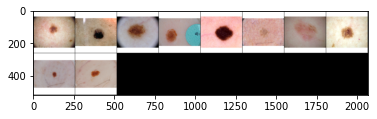

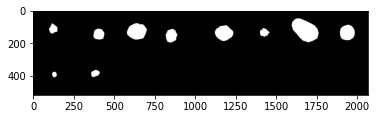

In [ ]:
# Visualize some examples

iterator = iter(train_loader)
data = next(iterator)

inputs = data['image']
masks = data['mask']

print(inputs.shape)
print(masks.shape)

ins = torchvision.utils.make_grid(inputs)
imshow(ins)
out = torchvision.utils.make_grid(masks)
imshow(out)

### **Start Training**

In [ ]:
#Hyperparameters
LEARNING_RATE = 1e-5 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 
NUM_EPOCHS = 100
N_CHANNELS = 3
N_CLASSES = 1
LR_PATIENCE = 5 #Learning Rate Patience
ES_PATIENCE = 10 #Early Stopping Patience Patience
CHECKPOINT_UNET_BCE_ADAM = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/unet_BCE_ADAM.pth'
CHECKPOINT_UNET_DiceBCE_ADAM = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/unet_DiceBCE_ADAM.pth'
CHECKPOINT_UNET_BCE_SGD = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/unet_BCE_SGD.pth'
CHECKPOINT_UNET_DiceBCE_SGD = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/unet_DiceBCE_SGD.pth'

CHECKPOINT_UNET_IOU_ADAM = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/unet_IOU_ADAM.pth'
CHECKPOINT_UNET_IOU_SGD = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/unet_IOU_SGD.pth'

WEIGHT_DECAY = 1e-8
MOMENTUM = 0.9 

### **BCE+ADAM**

In [ ]:
# create a new U-Net model
unet_bce_adam = UNET(in_channels=N_CHANNELS, out_channels=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.Adam(unet_bce_adam.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(unet_bce_adam, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

Valid: 150img [00:02, 63.08img/s, dice =0.274, loss =7.15]


Initial val dice: 0.1847, Initial val loss: 0.7151


In [ ]:
train_net(unet_bce_adam, 
          DEVICE,
          train_loader,  
          val_loader,
          ES_PATIENCE, 
          optimizer, 
          grad_scaler,
          scheduler, 
          criterion, 
          NUM_EPOCHS,
          True, 
          CHECKPOINT_UNET_BCE_ADAM,
          True) 

Epoch 1/100: 2000img [01:17, 25.84img/s, loss (batch)=0.369]


Training Loss: 0.46788


Valid: 150img [00:01, 77.45img/s, dice =0.533, loss =3.87]


Val Dice: 0.3480, Val Loss: 0.3869




Epoch 2/100: 2000img [01:17, 25.89img/s, loss (batch)=0.334]


Training Loss: 0.33070


Valid: 150img [00:01, 78.62img/s, dice =0.566, loss =3.26]


Val Dice: 0.3736, Val Loss: 0.3264




Epoch 3/100: 2000img [01:17, 25.88img/s, loss (batch)=0.307]


Training Loss: 0.29831


Valid: 150img [00:01, 78.36img/s, dice =0.565, loss =2.99]


Val Dice: 0.3763, Val Loss: 0.2987




Epoch 4/100: 2000img [01:17, 25.87img/s, loss (batch)=0.256]


Training Loss: 0.27555


Valid: 150img [00:01, 78.57img/s, dice =0.568, loss =2.8]


Val Dice: 0.3838, Val Loss: 0.2801




Epoch 5/100: 2000img [01:17, 25.87img/s, loss (batch)=0.245]


Training Loss: 0.26269


Valid: 150img [00:01, 77.47img/s, dice =0.596, loss =2.71]


Val Dice: 0.4079, Val Loss: 0.2712




Epoch 6/100: 2000img [01:17, 25.88img/s, loss (batch)=0.253]


Training Loss: 0.24865


Valid: 150img [00:01, 78.34img/s, dice =0.583, loss =2.71]


Val Dice: 0.3960, Val Loss: 0.2706




Epoch 7/100: 2000img [01:17, 25.88img/s, loss (batch)=0.221]


Training Loss: 0.23935


Valid: 150img [00:01, 77.86img/s, dice =0.615, loss =2.49]


Val Dice: 0.4221, Val Loss: 0.2487




Epoch 8/100: 2000img [01:17, 25.88img/s, loss (batch)=0.238]


Training Loss: 0.22926


Valid: 150img [00:01, 78.68img/s, dice =0.601, loss =2.56]


Val Dice: 0.4181, Val Loss: 0.2558




Epoch 9/100: 2000img [01:17, 25.88img/s, loss (batch)=0.202]


Training Loss: 0.22007


Valid: 150img [00:01, 78.59img/s, dice =0.64, loss =2.34]


Val Dice: 0.4509, Val Loss: 0.2344




Epoch 10/100: 2000img [01:17, 25.89img/s, loss (batch)=0.219]


Training Loss: 0.21378


Valid: 150img [00:01, 77.95img/s, dice =0.633, loss =2.32]


Val Dice: 0.4507, Val Loss: 0.2321




Epoch 11/100: 2000img [01:17, 25.88img/s, loss (batch)=0.199]


Training Loss: 0.20329


Valid: 150img [00:01, 78.11img/s, dice =0.641, loss =2.34]


Val Dice: 0.4397, Val Loss: 0.2340




Epoch 12/100: 2000img [01:17, 25.88img/s, loss (batch)=0.186]


Training Loss: 0.19830


Valid: 150img [00:01, 78.27img/s, dice =0.635, loss =2.37]


Val Dice: 0.4371, Val Loss: 0.2367




Epoch 13/100: 2000img [01:17, 25.88img/s, loss (batch)=0.2]


Training Loss: 0.18934


Valid: 150img [00:01, 78.01img/s, dice =0.659, loss =2.17]


Val Dice: 0.4705, Val Loss: 0.2174




Epoch 14/100: 2000img [01:17, 25.88img/s, loss (batch)=0.22]


Training Loss: 0.18193


Valid: 150img [00:01, 78.42img/s, dice =0.658, loss =2.07]


Val Dice: 0.4732, Val Loss: 0.2069




Epoch 15/100: 2000img [01:17, 25.88img/s, loss (batch)=0.164]


Training Loss: 0.17574


Valid: 150img [00:01, 78.58img/s, dice =0.668, loss =2.04]


Val Dice: 0.4873, Val Loss: 0.2040




Epoch 16/100: 2000img [01:17, 25.88img/s, loss (batch)=0.208]


Training Loss: 0.16836


Valid: 150img [00:01, 78.26img/s, dice =0.67, loss =2.08]


Val Dice: 0.4748, Val Loss: 0.2075




Epoch 17/100: 2000img [01:17, 25.89img/s, loss (batch)=0.16]


Training Loss: 0.16271


Valid: 150img [00:01, 78.08img/s, dice =0.675, loss =1.99]


Val Dice: 0.4907, Val Loss: 0.1991




Epoch 18/100: 2000img [01:17, 25.88img/s, loss (batch)=0.15]


Training Loss: 0.15807


Valid: 150img [00:01, 78.32img/s, dice =0.695, loss =1.86]


Val Dice: 0.5241, Val Loss: 0.1860




Epoch 19/100: 2000img [01:17, 25.87img/s, loss (batch)=0.128]


Training Loss: 0.15139


Valid: 150img [00:01, 78.64img/s, dice =0.691, loss =1.87]


Val Dice: 0.5117, Val Loss: 0.1874




Epoch 20/100: 2000img [01:17, 25.88img/s, loss (batch)=0.138]


Training Loss: 0.14480


Valid: 150img [00:01, 78.84img/s, dice =0.702, loss =1.82]


Val Dice: 0.5183, Val Loss: 0.1824




Epoch 21/100: 2000img [01:17, 25.88img/s, loss (batch)=0.161]


Training Loss: 0.13912


Valid: 150img [00:01, 77.83img/s, dice =0.711, loss =1.84]


Val Dice: 0.5311, Val Loss: 0.1843




Epoch 22/100: 2000img [01:17, 25.88img/s, loss (batch)=0.133]


Training Loss: 0.13400


Valid: 150img [00:01, 77.84img/s, dice =0.713, loss =1.83]


Val Dice: 0.5367, Val Loss: 0.1831




Epoch 23/100: 2000img [01:17, 25.88img/s, loss (batch)=0.124]


Training Loss: 0.13007


Valid: 150img [00:01, 78.03img/s, dice =0.701, loss =1.85]


Val Dice: 0.5164, Val Loss: 0.1851




Epoch 24/100: 2000img [01:17, 25.87img/s, loss (batch)=0.112]


Training Loss: 0.12445


Valid: 150img [00:01, 78.56img/s, dice =0.726, loss =1.72]


Val Dice: 0.5460, Val Loss: 0.1720




Epoch 25/100: 2000img [01:17, 25.87img/s, loss (batch)=0.118]


Training Loss: 0.11812


Valid: 150img [00:01, 78.29img/s, dice =0.725, loss =1.68]


Val Dice: 0.5537, Val Loss: 0.1676




Epoch 26/100: 2000img [01:17, 25.88img/s, loss (batch)=0.124]


Training Loss: 0.11574


Valid: 150img [00:01, 78.49img/s, dice =0.726, loss =1.76]


Val Dice: 0.5563, Val Loss: 0.1759




Epoch 27/100: 2000img [01:17, 25.89img/s, loss (batch)=0.108]


Training Loss: 0.11013


Valid: 150img [00:01, 78.16img/s, dice =0.741, loss =1.66]


Val Dice: 0.5632, Val Loss: 0.1663




Epoch 28/100: 2000img [01:17, 25.88img/s, loss (batch)=0.103]


Training Loss: 0.10494


Valid: 150img [00:01, 78.37img/s, dice =0.749, loss =1.62]


Val Dice: 0.5738, Val Loss: 0.1618




Epoch 29/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0952]


Training Loss: 0.10065


Valid: 150img [00:01, 77.67img/s, dice =0.747, loss =1.65]


Val Dice: 0.5791, Val Loss: 0.1654




Epoch 30/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0933]


Training Loss: 0.09757


Valid: 150img [00:01, 77.79img/s, dice =0.761, loss =1.63]


Val Dice: 0.5886, Val Loss: 0.1633




Epoch 31/100: 2000img [01:17, 25.86img/s, loss (batch)=0.0826]


Training Loss: 0.09362


Valid: 150img [00:01, 78.05img/s, dice =0.767, loss =1.59]


Val Dice: 0.5996, Val Loss: 0.1593




Epoch 32/100: 2000img [01:17, 25.86img/s, loss (batch)=0.0863]


Training Loss: 0.09129


Valid: 150img [00:01, 77.94img/s, dice =0.752, loss =1.65]


Val Dice: 0.5812, Val Loss: 0.1647




Epoch 33/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0852]


Training Loss: 0.08603


Valid: 150img [00:01, 78.22img/s, dice =0.75, loss =1.6]


Val Dice: 0.5993, Val Loss: 0.1599




Epoch 34/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0806]


Training Loss: 0.08274


Valid: 150img [00:01, 78.05img/s, dice =0.768, loss =1.6]


Val Dice: 0.5973, Val Loss: 0.1597




Epoch 35/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0734]


Training Loss: 0.08006


Valid: 150img [00:01, 78.31img/s, dice =0.761, loss =1.56]


Val Dice: 0.6108, Val Loss: 0.1559




Epoch 36/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0766]


Training Loss: 0.07610


Valid: 150img [00:01, 78.44img/s, dice =0.788, loss =1.53]


Val Dice: 0.6248, Val Loss: 0.1531




Epoch 37/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0763]


Training Loss: 0.07232


Valid: 150img [00:01, 78.29img/s, dice =0.778, loss =1.53]


Val Dice: 0.6215, Val Loss: 0.1533




Epoch 38/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0752]


Training Loss: 0.07118


Valid: 150img [00:01, 78.53img/s, dice =0.786, loss =1.48]


Val Dice: 0.6332, Val Loss: 0.1478




Epoch 39/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0607]


Training Loss: 0.06784


Valid: 150img [00:01, 78.21img/s, dice =0.782, loss =1.52]


Val Dice: 0.6324, Val Loss: 0.1524




Epoch 40/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0661]


Training Loss: 0.06633


Valid: 150img [00:01, 77.96img/s, dice =0.801, loss =1.46]


Val Dice: 0.6555, Val Loss: 0.1457




Epoch 41/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0628]


Training Loss: 0.06460


Valid: 150img [00:01, 78.06img/s, dice =0.78, loss =1.53]


Val Dice: 0.6231, Val Loss: 0.1530




Epoch 42/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0606]


Training Loss: 0.06720


Valid: 150img [00:01, 77.98img/s, dice =0.794, loss =1.41]


Val Dice: 0.6441, Val Loss: 0.1415




Epoch 43/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0666]


Training Loss: 0.05886


Valid: 150img [00:01, 78.58img/s, dice =0.785, loss =1.56]


Val Dice: 0.6486, Val Loss: 0.1559




Epoch 44/100: 2000img [01:17, 25.89img/s, loss (batch)=0.0578]


Training Loss: 0.05548


Valid: 150img [00:01, 78.00img/s, dice =0.792, loss =1.54]


Val Dice: 0.6534, Val Loss: 0.1538




Epoch 45/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0526]


Training Loss: 0.05322


Valid: 150img [00:01, 78.62img/s, dice =0.795, loss =1.56]


Val Dice: 0.6545, Val Loss: 0.1559




Epoch 46/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0543]


Training Loss: 0.05048


Valid: 150img [00:01, 78.41img/s, dice =0.8, loss =1.5]


Val Dice: 0.6600, Val Loss: 0.1503




Epoch 47/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0493]


Training Loss: 0.04859


Valid: 150img [00:01, 78.36img/s, dice =0.794, loss =1.57]


Val Dice: 0.6624, Val Loss: 0.1570




Epoch 48/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0495]


Training Loss: 0.04739


Valid: 150img [00:01, 78.09img/s, dice =0.816, loss =1.53]


Val Dice: 0.6731, Val Loss: 0.1528




Epoch 49/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0449]


Training Loss: 0.04439


Valid: 150img [00:01, 77.19img/s, dice =0.816, loss =1.5]


Val Dice: 0.6826, Val Loss: 0.1505




Epoch 50/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0377]


Training Loss: 0.04373


Valid: 150img [00:01, 77.58img/s, dice =0.82, loss =1.51]


Val Dice: 0.6827, Val Loss: 0.1513




Epoch 51/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0418]


Training Loss: 0.04302


Valid: 150img [00:01, 78.57img/s, dice =0.815, loss =1.54]


Val Dice: 0.6813, Val Loss: 0.1542




Epoch 52/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0483]


Training Loss: 0.04269


Valid: 150img [00:01, 78.15img/s, dice =0.818, loss =1.53]


Val Dice: 0.6819, Val Loss: 0.1532




Epoch 53/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0407]


Training Loss: 0.04250


Valid: 150img [00:01, 78.48img/s, dice =0.815, loss =1.54]


Val Dice: 0.6816, Val Loss: 0.1538




Epoch 54/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0393]


Training Loss: 0.04192


Valid: 150img [00:01, 78.46img/s, dice =0.814, loss =1.55]


Val Dice: 0.6806, Val Loss: 0.1548




Epoch 55/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0403]


Training Loss: 0.04164


Valid: 150img [00:01, 78.26img/s, dice =0.812, loss =1.57]


Val Dice: 0.6801, Val Loss: 0.1566




Epoch 56/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0392]


Training Loss: 0.04127


Valid: 150img [00:01, 78.24img/s, dice =0.817, loss =1.55]


Val Dice: 0.6848, Val Loss: 0.1548




Epoch 57/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0482]


Training Loss: 0.04162


Valid: 150img [00:01, 78.51img/s, dice =0.815, loss =1.56]


Val Dice: 0.6797, Val Loss: 0.1555




Epoch 58/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0398]


Training Loss: 0.04134


Valid: 150img [00:01, 78.35img/s, dice =0.815, loss =1.56]


Val Dice: 0.6781, Val Loss: 0.1557




Epoch 59/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0427]


Training Loss: 0.04122


Valid: 150img [00:01, 77.65img/s, dice =0.814, loss =1.56]


Val Dice: 0.6799, Val Loss: 0.1559




Epoch 60/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0448]


Training Loss: 0.04133


Valid: 150img [00:01, 78.16img/s, dice =0.816, loss =1.56]


Val Dice: 0.6817, Val Loss: 0.1557




Epoch 61/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0373]


Training Loss: 0.04145


Valid: 150img [00:01, 78.64img/s, dice =0.816, loss =1.54]


Val Dice: 0.6813, Val Loss: 0.1544




Epoch 62/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0362]


Training Loss: 0.04128


Valid: 150img [00:01, 77.62img/s, dice =0.816, loss =1.55]


Val Dice: 0.6879, Val Loss: 0.1551




Epoch 63/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0433]


Training Loss: 0.04127


Valid: 150img [00:01, 78.49img/s, dice =0.817, loss =1.55]


Val Dice: 0.6812, Val Loss: 0.1546




Epoch 64/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0426]


Training Loss: 0.04126


Valid: 150img [00:01, 77.73img/s, dice =0.816, loss =1.56]


Val Dice: 0.6819, Val Loss: 0.1559




Epoch 65/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0362]


Training Loss: 0.04147


Valid: 150img [00:01, 78.00img/s, dice =0.815, loss =1.55]


Val Dice: 0.6821, Val Loss: 0.1554




Epoch 66/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0377]


Training Loss: 0.04124


Valid: 150img [00:01, 78.08img/s, dice =0.816, loss =1.55]


Val Dice: 0.6808, Val Loss: 0.1551




Epoch 67/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0555]


Training Loss: 0.04144


Valid: 150img [00:01, 78.66img/s, dice =0.818, loss =1.55]


Val Dice: 0.6833, Val Loss: 0.1548




Epoch 68/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0339]


Training Loss: 0.04144


Valid: 150img [00:01, 77.96img/s, dice =0.819, loss =1.54]


Val Dice: 0.6866, Val Loss: 0.1543




Epoch 69/100: 2000img [01:17, 25.86img/s, loss (batch)=0.0461]


Training Loss: 0.04132


Valid: 150img [00:01, 78.35img/s, dice =0.817, loss =1.55]


Val Dice: 0.6808, Val Loss: 0.1553




Epoch 70/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0367]


Training Loss: 0.04145


Valid: 150img [00:01, 78.17img/s, dice =0.816, loss =1.57]


Val Dice: 0.6811, Val Loss: 0.1567




Epoch 71/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0413]


Training Loss: 0.04134


Valid: 150img [00:01, 78.36img/s, dice =0.82, loss =1.55]


Val Dice: 0.6858, Val Loss: 0.1545




Epoch 72/100: 2000img [01:17, 25.86img/s, loss (batch)=0.0398]


Training Loss: 0.04121


Valid: 150img [00:01, 77.17img/s, dice =0.817, loss =1.56]


Val Dice: 0.6834, Val Loss: 0.1561




Epoch 73/100: 2000img [01:17, 25.87img/s, loss (batch)=0.0362]


Training Loss: 0.04151


Valid: 150img [00:01, 78.58img/s, dice =0.818, loss =1.55]


Val Dice: 0.6824, Val Loss: 0.1552
EARLY STOPPING AFTER 73 EPOCHS


**Finding the optimal threshold with Bayesian search**

In [ ]:
# Load the best weights obtained to the model
unet_bce_adam.load_state_dict(torch.load(CHECKPOINT_UNET_BCE_ADAM))
unet_bce_adam.eval()

UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard_in(th):
  return check_js(val_loader, unet_bce_adam, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard_in, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.3679   |  0.3745   |
|  2        |  0.1094   |  0.9507   |
|  3        |  0.3677   |  0.373    |
|  4        |  0.1217   |  0.0      |
|  5        |  0.3647   |  0.6099   |
|  6        |  0.378    |  0.5144   |
|  7        |  0.3762   |  0.4593   |
|  8        |  0.3745   |  0.5538   |
|  9        |  0.3782   |  0.4915   |
|  10       |  0.3783   |  0.501    |
|  11       |  0.3783   |  0.5004   |
|  12       |  0.3783   |  0.5001   |


In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_unet_bce_adam = optimizer.max['params']['th']
print(f"The optimal threshold is {th_unet_bce_adam:.4f}")

The optimal threshold is 0.5001


### **IOU+ADAM**

In [ ]:
# create a new U-Net model
unet_iou_adam = UNET(in_channels=N_CHANNELS, out_channels=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.Adam(unet_iou_adam.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = IoULoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(unet_iou_adam, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

Valid: 16img [00:00, 117.04img/s]             /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Valid: 150img [00:01, 79.05img/s, dice =0.276, loss =8.94]


Initial val dice: 0.1857, Initial val loss: 0.8945


In [ ]:
train_net(unet_iou_adam, 
          DEVICE,
          train_loader,  
          val_loader,
          ES_PATIENCE, 
          optimizer, 
          grad_scaler,
          scheduler, 
          criterion, 
          NUM_EPOCHS,
          True, 
          CHECKPOINT_UNET_IOU_ADAM,
          True) 

Epoch 1/100:   0%|          | 0/200 [00:00<?, ?img/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 1/100: 2000img [01:17, 25.87img/s, loss (batch)=0.718]


Training Loss: 0.75171


Valid: 150img [00:01, 78.41img/s, dice =0.537, loss =7.55]


Val Dice: 0.3776, Val Loss: 0.7551




Epoch 2/100: 2000img [01:17, 25.90img/s, loss (batch)=0.629]


Training Loss: 0.68703


Valid: 150img [00:01, 78.93img/s, dice =0.568, loss =7.39]


Val Dice: 0.3996, Val Loss: 0.7392




Epoch 3/100: 2000img [01:17, 25.91img/s, loss (batch)=0.761]


Training Loss: 0.66838


Valid: 150img [00:01, 78.81img/s, dice =0.555, loss =7.42]


Val Dice: 0.3937, Val Loss: 0.7421




Epoch 4/100: 2000img [01:17, 25.90img/s, loss (batch)=0.523]


Training Loss: 0.65548


Valid: 150img [00:01, 78.88img/s, dice =0.578, loss =7.27]


Val Dice: 0.4134, Val Loss: 0.7269




Epoch 5/100: 2000img [01:17, 25.90img/s, loss (batch)=0.504]


Training Loss: 0.64612


Valid: 150img [00:01, 78.76img/s, dice =0.618, loss =7.15]


Val Dice: 0.4254, Val Loss: 0.7153




Epoch 6/100: 2000img [01:17, 25.90img/s, loss (batch)=0.724]


Training Loss: 0.63596


Valid: 150img [00:01, 78.88img/s, dice =0.601, loss =7.2]


Val Dice: 0.4233, Val Loss: 0.7202




Epoch 7/100: 2000img [01:17, 25.90img/s, loss (batch)=0.755]


Training Loss: 0.62852


Valid: 150img [00:01, 78.68img/s, dice =0.621, loss =7.18]


Val Dice: 0.4255, Val Loss: 0.7176




Epoch 8/100: 2000img [01:17, 25.90img/s, loss (batch)=0.477]


Training Loss: 0.61925


Valid: 150img [00:01, 78.86img/s, dice =0.622, loss =6.95]


Val Dice: 0.4509, Val Loss: 0.6955




Epoch 9/100: 2000img [01:17, 25.89img/s, loss (batch)=0.663]


Training Loss: 0.60999


Valid: 150img [00:01, 77.76img/s, dice =0.61, loss =6.97]


Val Dice: 0.4519, Val Loss: 0.6972




Epoch 10/100: 2000img [01:17, 25.90img/s, loss (batch)=0.682]


Training Loss: 0.60103


Valid: 150img [00:01, 78.58img/s, dice =0.629, loss =6.96]


Val Dice: 0.4515, Val Loss: 0.6964




Epoch 11/100: 2000img [01:17, 25.90img/s, loss (batch)=0.718]


Training Loss: 0.58992


Valid: 150img [00:01, 79.04img/s, dice =0.648, loss =6.83]


Val Dice: 0.4677, Val Loss: 0.6826




Epoch 12/100: 2000img [01:17, 25.90img/s, loss (batch)=0.587]


Training Loss: 0.58093


Valid: 150img [00:01, 78.72img/s, dice =0.649, loss =6.77]


Val Dice: 0.4743, Val Loss: 0.6772




Epoch 13/100: 2000img [01:17, 25.90img/s, loss (batch)=0.623]


Training Loss: 0.57031


Valid: 150img [00:01, 79.24img/s, dice =0.659, loss =6.61]


Val Dice: 0.4917, Val Loss: 0.6614




Epoch 14/100: 2000img [01:17, 25.89img/s, loss (batch)=0.628]


Training Loss: 0.56298


Valid: 150img [00:01, 78.98img/s, dice =0.659, loss =6.75]


Val Dice: 0.4771, Val Loss: 0.6746




Epoch 15/100: 2000img [01:17, 25.90img/s, loss (batch)=0.522]


Training Loss: 0.55054


Valid: 150img [00:01, 78.93img/s, dice =0.663, loss =6.6]


Val Dice: 0.4948, Val Loss: 0.6600




Epoch 16/100: 2000img [01:17, 25.90img/s, loss (batch)=0.683]


Training Loss: 0.53960


Valid: 150img [00:01, 78.38img/s, dice =0.682, loss =6.53]


Val Dice: 0.5016, Val Loss: 0.6534




Epoch 17/100: 2000img [01:17, 25.90img/s, loss (batch)=0.566]


Training Loss: 0.53275


Valid: 150img [00:01, 78.40img/s, dice =0.674, loss =6.48]


Val Dice: 0.5071, Val Loss: 0.6477




Epoch 18/100: 2000img [01:17, 25.90img/s, loss (batch)=0.531]


Training Loss: 0.52141


Valid: 150img [00:01, 78.99img/s, dice =0.68, loss =6.39]


Val Dice: 0.5184, Val Loss: 0.6387




Epoch 19/100: 2000img [01:17, 25.91img/s, loss (batch)=0.465]


Training Loss: 0.51314


Valid: 150img [00:01, 79.05img/s, dice =0.69, loss =6.25]


Val Dice: 0.5331, Val Loss: 0.6254




Epoch 20/100: 2000img [01:17, 25.90img/s, loss (batch)=0.416]


Training Loss: 0.50323


Valid: 150img [00:01, 78.98img/s, dice =0.694, loss =6.25]


Val Dice: 0.5325, Val Loss: 0.6255




Epoch 21/100: 2000img [01:17, 25.91img/s, loss (batch)=0.567]


Training Loss: 0.49240


Valid: 150img [00:01, 78.48img/s, dice =0.701, loss =6.3]


Val Dice: 0.5283, Val Loss: 0.6304




Epoch 22/100: 2000img [01:17, 25.91img/s, loss (batch)=0.352]


Training Loss: 0.48471


Valid: 150img [00:01, 78.83img/s, dice =0.716, loss =6.1]


Val Dice: 0.5487, Val Loss: 0.6102




Epoch 23/100: 2000img [01:17, 25.90img/s, loss (batch)=0.343]


Training Loss: 0.47117


Valid: 150img [00:01, 78.21img/s, dice =0.693, loss =6.23]


Val Dice: 0.5375, Val Loss: 0.6228




Epoch 24/100: 2000img [01:17, 25.89img/s, loss (batch)=0.545]


Training Loss: 0.46190


Valid: 150img [00:01, 78.90img/s, dice =0.704, loss =6.18]


Val Dice: 0.5407, Val Loss: 0.6181




Epoch 25/100: 2000img [01:17, 25.90img/s, loss (batch)=0.415]


Training Loss: 0.44848


Valid: 150img [00:01, 79.23img/s, dice =0.728, loss =6.01]


Val Dice: 0.5583, Val Loss: 0.6011




Epoch 26/100: 2000img [01:17, 25.90img/s, loss (batch)=0.425]


Training Loss: 0.43825


Valid: 150img [00:01, 78.36img/s, dice =0.747, loss =5.9]


Val Dice: 0.5690, Val Loss: 0.5896




Epoch 27/100: 2000img [01:17, 25.91img/s, loss (batch)=0.562]


Training Loss: 0.43207


Valid: 150img [00:01, 79.14img/s, dice =0.726, loss =5.99]


Val Dice: 0.5618, Val Loss: 0.5988




Epoch 28/100: 2000img [01:17, 25.90img/s, loss (batch)=0.429]


Training Loss: 0.42053


Valid: 150img [00:01, 79.00img/s, dice =0.745, loss =5.77]


Val Dice: 0.5834, Val Loss: 0.5770




Epoch 29/100: 2000img [01:17, 25.90img/s, loss (batch)=0.319]


Training Loss: 0.41311


Valid: 150img [00:01, 79.11img/s, dice =0.744, loss =5.81]


Val Dice: 0.5777, Val Loss: 0.5814




Epoch 30/100: 2000img [01:17, 25.89img/s, loss (batch)=0.216]


Training Loss: 0.39777


Valid: 150img [00:01, 79.02img/s, dice =0.769, loss =5.73]


Val Dice: 0.5863, Val Loss: 0.5727




Epoch 31/100: 2000img [01:17, 25.91img/s, loss (batch)=0.336]


Training Loss: 0.38977


Valid: 150img [00:01, 78.13img/s, dice =0.768, loss =5.64]


Val Dice: 0.5962, Val Loss: 0.5644




Epoch 32/100: 2000img [01:17, 25.90img/s, loss (batch)=0.36]


Training Loss: 0.38015


Valid: 150img [00:01, 78.81img/s, dice =0.751, loss =5.75]


Val Dice: 0.5856, Val Loss: 0.5753




Epoch 33/100: 2000img [01:17, 25.91img/s, loss (batch)=0.327]


Training Loss: 0.37049


Valid: 150img [00:01, 78.71img/s, dice =0.762, loss =5.72]


Val Dice: 0.5891, Val Loss: 0.5717




Epoch 34/100: 2000img [01:17, 25.90img/s, loss (batch)=0.435]


Training Loss: 0.36090


Valid: 150img [00:01, 78.62img/s, dice =0.756, loss =5.61]


Val Dice: 0.5999, Val Loss: 0.5614




Epoch 35/100: 2000img [01:17, 25.90img/s, loss (batch)=0.465]


Training Loss: 0.34964


Valid: 150img [00:01, 78.63img/s, dice =0.78, loss =5.5]


Val Dice: 0.6110, Val Loss: 0.5497




Epoch 36/100: 2000img [01:17, 25.90img/s, loss (batch)=0.394]


Training Loss: 0.34126


Valid: 150img [00:01, 79.21img/s, dice =0.777, loss =5.57]


Val Dice: 0.6049, Val Loss: 0.5568




Epoch 37/100: 2000img [01:17, 25.91img/s, loss (batch)=0.2]


Training Loss: 0.32993


Valid: 150img [00:01, 79.23img/s, dice =0.799, loss =5.32]


Val Dice: 0.6282, Val Loss: 0.5316




Epoch 38/100: 2000img [01:17, 25.90img/s, loss (batch)=0.292]


Training Loss: 0.32434


Valid: 150img [00:01, 78.42img/s, dice =0.79, loss =5.21]


Val Dice: 0.6390, Val Loss: 0.5211




Epoch 39/100: 2000img [01:17, 25.90img/s, loss (batch)=0.407]


Training Loss: 0.30774


Valid: 150img [00:01, 79.00img/s, dice =0.795, loss =5.3]


Val Dice: 0.6299, Val Loss: 0.5304




Epoch 40/100: 2000img [01:17, 25.90img/s, loss (batch)=0.253]


Training Loss: 0.29867


Valid: 150img [00:01, 78.66img/s, dice =0.807, loss =5.16]


Val Dice: 0.6426, Val Loss: 0.5160




Epoch 41/100: 2000img [01:17, 25.90img/s, loss (batch)=0.322]


Training Loss: 0.29559


Valid: 150img [00:01, 79.03img/s, dice =0.798, loss =5.2]


Val Dice: 0.6394, Val Loss: 0.5200




Epoch 42/100: 2000img [01:17, 25.90img/s, loss (batch)=0.406]


Training Loss: 0.28226


Valid: 150img [00:01, 78.54img/s, dice =0.81, loss =5.16]


Val Dice: 0.6419, Val Loss: 0.5159




Epoch 43/100: 2000img [01:17, 25.90img/s, loss (batch)=0.391]


Training Loss: 0.27824


Valid: 150img [00:01, 79.18img/s, dice =0.819, loss =4.89]


Val Dice: 0.6657, Val Loss: 0.4887




Epoch 44/100: 2000img [01:17, 25.90img/s, loss (batch)=0.29]


Training Loss: 0.26683


Valid: 150img [00:01, 78.79img/s, dice =0.816, loss =5.02]


Val Dice: 0.6551, Val Loss: 0.5023




Epoch 45/100: 2000img [01:17, 25.91img/s, loss (batch)=0.26]


Training Loss: 0.25783


Valid: 150img [00:01, 79.04img/s, dice =0.824, loss =4.82]


Val Dice: 0.6741, Val Loss: 0.4818




Epoch 46/100: 2000img [01:17, 25.90img/s, loss (batch)=0.174]


Training Loss: 0.24624


Valid: 150img [00:01, 78.52img/s, dice =0.825, loss =4.73]


Val Dice: 0.6822, Val Loss: 0.4729




Epoch 47/100: 2000img [01:17, 25.90img/s, loss (batch)=0.24]


Training Loss: 0.24486


Valid: 150img [00:01, 78.85img/s, dice =0.824, loss =4.72]


Val Dice: 0.6839, Val Loss: 0.4715




Epoch 48/100: 2000img [01:17, 25.90img/s, loss (batch)=0.216]


Training Loss: 0.23229


Valid: 150img [00:01, 78.70img/s, dice =0.815, loss =4.88]


Val Dice: 0.6691, Val Loss: 0.4884




Epoch 49/100: 2000img [01:17, 25.90img/s, loss (batch)=0.25]


Training Loss: 0.22760


Valid: 150img [00:01, 78.76img/s, dice =0.831, loss =4.87]


Val Dice: 0.6686, Val Loss: 0.4873




Epoch 50/100: 2000img [01:17, 25.91img/s, loss (batch)=0.305]


Training Loss: 0.22122


Valid: 150img [00:01, 78.64img/s, dice =0.832, loss =4.76]


Val Dice: 0.6799, Val Loss: 0.4757




Epoch 51/100: 2000img [01:17, 25.90img/s, loss (batch)=0.223]


Training Loss: 0.21599


Valid: 150img [00:01, 78.50img/s, dice =0.833, loss =4.52]


Val Dice: 0.7005, Val Loss: 0.4524




Epoch 52/100: 2000img [01:17, 25.89img/s, loss (batch)=0.25]


Training Loss: 0.20879


Valid: 150img [00:01, 79.17img/s, dice =0.845, loss =4.57]


Val Dice: 0.6959, Val Loss: 0.4568




Epoch 53/100: 2000img [01:17, 25.90img/s, loss (batch)=0.12]


Training Loss: 0.20299


Valid: 150img [00:01, 79.17img/s, dice =0.824, loss =4.77]


Val Dice: 0.6802, Val Loss: 0.4766




Epoch 54/100: 2000img [01:17, 25.90img/s, loss (batch)=0.14]


Training Loss: 0.19140


Valid: 150img [00:01, 78.96img/s, dice =0.842, loss =4.49]


Val Dice: 0.7034, Val Loss: 0.4490




Epoch 55/100: 2000img [01:17, 25.90img/s, loss (batch)=0.157]


Training Loss: 0.18547


Valid: 150img [00:01, 78.92img/s, dice =0.846, loss =4.26]


Val Dice: 0.7235, Val Loss: 0.4260




Epoch 56/100: 2000img [01:17, 25.89img/s, loss (batch)=0.432]


Training Loss: 0.17869


Valid: 150img [00:01, 79.21img/s, dice =0.838, loss =4.47]


Val Dice: 0.7050, Val Loss: 0.4473




Epoch 57/100: 2000img [01:17, 25.90img/s, loss (batch)=0.186]


Training Loss: 0.17604


Valid: 150img [00:01, 79.34img/s, dice =0.842, loss =4.37]


Val Dice: 0.7133, Val Loss: 0.4374




Epoch 58/100: 2000img [01:17, 25.90img/s, loss (batch)=0.162]


Training Loss: 0.16848


Valid: 150img [00:01, 79.21img/s, dice =0.848, loss =4.38]


Val Dice: 0.7121, Val Loss: 0.4382




Epoch 59/100: 2000img [01:17, 25.90img/s, loss (batch)=0.219]


Training Loss: 0.16099


Valid: 150img [00:01, 78.67img/s, dice =0.867, loss =4.13]


Val Dice: 0.7325, Val Loss: 0.4135




Epoch 60/100: 2000img [01:17, 25.90img/s, loss (batch)=0.0906]


Training Loss: 0.15694


Valid: 150img [00:01, 78.94img/s, dice =0.851, loss =4.3]


Val Dice: 0.7187, Val Loss: 0.4304




Epoch 61/100: 2000img [01:17, 25.89img/s, loss (batch)=0.145]


Training Loss: 0.15457


Valid: 150img [00:01, 78.23img/s, dice =0.848, loss =4.33]


Val Dice: 0.7166, Val Loss: 0.4328




Epoch 62/100: 2000img [01:17, 25.90img/s, loss (batch)=0.0904]


Training Loss: 0.14919


Valid: 150img [00:01, 78.91img/s, dice =0.857, loss =4.27]


Val Dice: 0.7210, Val Loss: 0.4273




Epoch 63/100: 2000img [01:17, 25.91img/s, loss (batch)=0.0832]


Training Loss: 0.14442


Valid: 150img [00:01, 78.87img/s, dice =0.864, loss =4.16]


Val Dice: 0.7299, Val Loss: 0.4161




Epoch 64/100: 2000img [01:17, 25.89img/s, loss (batch)=0.145]


Training Loss: 0.14123


Valid: 150img [00:01, 78.84img/s, dice =0.861, loss =4.11]


Val Dice: 0.7347, Val Loss: 0.4110




Epoch 65/100: 2000img [01:17, 25.88img/s, loss (batch)=0.084]


Training Loss: 0.14006


Valid: 150img [00:01, 78.86img/s, dice =0.855, loss =3.99]


Val Dice: 0.7448, Val Loss: 0.3989




Epoch 66/100: 2000img [01:17, 25.90img/s, loss (batch)=0.151]


Training Loss: 0.13002


Valid: 150img [00:01, 79.22img/s, dice =0.86, loss =4.11]


Val Dice: 0.7342, Val Loss: 0.4113




Epoch 67/100: 2000img [01:17, 25.89img/s, loss (batch)=0.0869]


Training Loss: 0.12654


Valid: 150img [00:01, 79.27img/s, dice =0.865, loss =4.07]


Val Dice: 0.7364, Val Loss: 0.4070




Epoch 68/100: 2000img [01:17, 25.91img/s, loss (batch)=0.16]


Training Loss: 0.13297


Valid: 150img [00:01, 78.70img/s, dice =0.877, loss =3.91]


Val Dice: 0.7506, Val Loss: 0.3913




Epoch 69/100: 2000img [01:17, 25.90img/s, loss (batch)=0.121]


Training Loss: 0.11570


Valid: 150img [00:01, 78.72img/s, dice =0.867, loss =4.09]


Val Dice: 0.7360, Val Loss: 0.4090




Epoch 70/100: 2000img [01:17, 25.90img/s, loss (batch)=0.103]


Training Loss: 0.11301


Valid: 150img [00:01, 79.17img/s, dice =0.873, loss =3.86]


Val Dice: 0.7544, Val Loss: 0.3860




Epoch 71/100: 2000img [01:17, 25.90img/s, loss (batch)=0.149]


Training Loss: 0.10974


Valid: 150img [00:01, 78.58img/s, dice =0.87, loss =3.9]


Val Dice: 0.7510, Val Loss: 0.3901




Epoch 72/100: 2000img [01:17, 25.90img/s, loss (batch)=0.117]


Training Loss: 0.10683


Valid: 150img [00:01, 78.79img/s, dice =0.877, loss =3.98]


Val Dice: 0.7444, Val Loss: 0.3981




Epoch 73/100: 2000img [01:17, 25.90img/s, loss (batch)=0.055]


Training Loss: 0.10564


Valid: 150img [00:01, 78.97img/s, dice =0.871, loss =3.97]


Val Dice: 0.7453, Val Loss: 0.3971




Epoch 74/100: 2000img [01:17, 25.90img/s, loss (batch)=0.0928]


Training Loss: 0.10050


Valid: 150img [00:01, 78.34img/s, dice =0.873, loss =3.81]


Val Dice: 0.7586, Val Loss: 0.3807




Epoch 75/100: 2000img [01:17, 25.90img/s, loss (batch)=0.14]


Training Loss: 0.09684


Valid: 150img [00:01, 78.93img/s, dice =0.871, loss =3.86]


Val Dice: 0.7540, Val Loss: 0.3861




Epoch 76/100: 2000img [01:17, 25.89img/s, loss (batch)=0.0537]


Training Loss: 0.09379


Valid: 150img [00:01, 79.02img/s, dice =0.877, loss =3.74]


Val Dice: 0.7636, Val Loss: 0.3741




Epoch 77/100: 2000img [01:17, 25.90img/s, loss (batch)=0.0563]


Training Loss: 0.08856


Valid: 150img [00:01, 78.79img/s, dice =0.874, loss =3.87]


Val Dice: 0.7531, Val Loss: 0.3869




Epoch 78/100: 2000img [01:17, 25.90img/s, loss (batch)=0.0792]


Training Loss: 0.08829


Valid: 150img [00:01, 78.70img/s, dice =0.89, loss =3.75]


Val Dice: 0.7618, Val Loss: 0.3752




Epoch 79/100: 2000img [01:17, 25.90img/s, loss (batch)=0.0428]


Training Loss: 0.08614


Valid: 150img [00:01, 78.69img/s, dice =0.883, loss =3.56]


Val Dice: 0.7774, Val Loss: 0.3564




Epoch 80/100: 2000img [01:17, 25.89img/s, loss (batch)=0.0514]


Training Loss: 0.08162


Valid: 150img [00:01, 78.75img/s, dice =0.869, loss =3.77]


Val Dice: 0.7615, Val Loss: 0.3769




Epoch 81/100: 2000img [01:17, 25.89img/s, loss (batch)=0.0639]


Training Loss: 0.07963


Valid: 150img [00:01, 78.94img/s, dice =0.886, loss =3.71]


Val Dice: 0.7657, Val Loss: 0.3705




Epoch 82/100: 2000img [01:17, 25.89img/s, loss (batch)=0.0367]


Training Loss: 0.07663


Valid: 150img [00:01, 79.29img/s, dice =0.878, loss =3.76]


Val Dice: 0.7621, Val Loss: 0.3758




Epoch 83/100: 2000img [01:17, 25.90img/s, loss (batch)=0.0535]


Training Loss: 0.07423


Valid: 150img [00:01, 78.98img/s, dice =0.887, loss =3.64]


Val Dice: 0.7708, Val Loss: 0.3640




Epoch 84/100: 2000img [01:17, 25.89img/s, loss (batch)=0.0906]


Training Loss: 0.07430


Valid: 150img [00:01, 78.79img/s, dice =0.883, loss =3.67]


Val Dice: 0.7679, Val Loss: 0.3672




Epoch 85/100: 2000img [01:17, 25.90img/s, loss (batch)=0.0774]


Training Loss: 0.07213


Valid: 150img [00:01, 78.68img/s, dice =0.88, loss =3.75]


Val Dice: 0.7623, Val Loss: 0.3750




Epoch 86/100: 2000img [01:17, 25.90img/s, loss (batch)=0.0797]


Training Loss: 0.06906


Valid: 150img [00:01, 79.15img/s, dice =0.88, loss =3.68]


Val Dice: 0.7678, Val Loss: 0.3679




Epoch 87/100: 2000img [01:17, 25.90img/s, loss (batch)=0.0515]


Training Loss: 0.06479


Valid: 150img [00:01, 79.14img/s, dice =0.881, loss =3.65]


Val Dice: 0.7698, Val Loss: 0.3651




Epoch 88/100: 2000img [01:17, 25.90img/s, loss (batch)=0.054]


Training Loss: 0.06322


Valid: 150img [00:01, 78.94img/s, dice =0.88, loss =3.69]


Val Dice: 0.7666, Val Loss: 0.3693




Epoch 89/100: 2000img [01:17, 25.90img/s, loss (batch)=0.0893]


Training Loss: 0.06465


Valid: 150img [00:01, 78.75img/s, dice =0.883, loss =3.67]


Val Dice: 0.7682, Val Loss: 0.3671




Epoch 90/100: 2000img [01:17, 25.89img/s, loss (batch)=0.0448]


Training Loss: 0.06286


Valid: 150img [00:01, 78.75img/s, dice =0.882, loss =3.66]


Val Dice: 0.7692, Val Loss: 0.3657
EARLY STOPPING AFTER 90 EPOCHS


**Finding the optimal threshold with Bayesian search**

In [ ]:
# Load the best weights obtained to the model
unet_iou_adam.load_state_dict(torch.load(CHECKPOINT_UNET_IOU_ADAM))
unet_iou_adam.eval()

UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard_in(th):
  return check_js(val_loader, unet_iou_adam, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard_in, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.6702   |  0.3745   |
|  2        |  0.6659   |  0.9507   |
|  3        |  0.6702   |  0.373    |
|  4        |  0.1217   |  0.0      |
|  5        |  0.6686   |  0.7023   |
|  6        |  0.6677   |  0.8283   |
|  7        |  0.6693   |  0.5563   |
|  8        |  0.0      |  1.0      |
|  9        |  0.6686   |  0.7023   |
|  10       |  0.6668   |  0.9041   |
|  11       |  0.6681   |  0.7673   |
|  12       |  0.669    |  0.6242   |


In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_unet_iou_adam = optimizer.max['params']['th']
print(f"The optimal threshold is {th_unet_iou_adam:.4f}")

The optimal threshold is 0.3730


### **BCE+SGD**

In [ ]:
# create a new U-Net model
unet_bce_sgd = UNET(in_channels=N_CHANNELS, out_channels=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.SGD(unet_bce_sgd.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(unet_bce_sgd, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

Valid: 150img [00:01, 77.73img/s, dice =0.27, loss =6.7]


Initial val dice: 0.1824, Initial val loss: 0.6702


In [ ]:
train_net(unet_bce_sgd, 
          DEVICE,
          train_loader,  
          val_loader,
          ES_PATIENCE, 
          optimizer, 
          grad_scaler,
          scheduler, 
          criterion, 
          NUM_EPOCHS,
          True, 
          CHECKPOINT_UNET_BCE_SGD,
          True) 

Epoch 1/100: 2000img [01:16, 26.15img/s, loss (batch)=0.647]


Training Loss: 0.66222


Valid: 150img [00:01, 78.90img/s, dice =0.378, loss =6.41]


Val Dice: 0.2427, Val Loss: 0.6407




Epoch 2/100: 2000img [01:16, 26.14img/s, loss (batch)=0.612]


Training Loss: 0.60020


Valid: 150img [00:01, 78.57img/s, dice =0.399, loss =5.84]


Val Dice: 0.2557, Val Loss: 0.5835




Epoch 3/100: 2000img [01:16, 26.13img/s, loss (batch)=0.524]


Training Loss: 0.55918


Valid: 150img [00:01, 78.79img/s, dice =0.414, loss =5.51]


Val Dice: 0.2661, Val Loss: 0.5506




Epoch 4/100: 2000img [01:16, 26.14img/s, loss (batch)=0.47]


Training Loss: 0.52722


Valid: 150img [00:01, 78.45img/s, dice =0.43, loss =5.47]


Val Dice: 0.2780, Val Loss: 0.5473




Epoch 5/100: 2000img [01:16, 26.14img/s, loss (batch)=0.486]


Training Loss: 0.50293


Valid: 150img [00:01, 78.51img/s, dice =0.436, loss =5.18]


Val Dice: 0.2831, Val Loss: 0.5184




Epoch 6/100: 2000img [01:16, 26.13img/s, loss (batch)=0.441]


Training Loss: 0.48022


Valid: 150img [00:01, 78.40img/s, dice =0.447, loss =5.16]


Val Dice: 0.2909, Val Loss: 0.5159




Epoch 7/100: 2000img [01:16, 26.14img/s, loss (batch)=0.404]


Training Loss: 0.46115


Valid: 150img [00:01, 78.66img/s, dice =0.449, loss =4.84]


Val Dice: 0.2924, Val Loss: 0.4844




Epoch 8/100: 2000img [01:16, 26.13img/s, loss (batch)=0.413]


Training Loss: 0.44697


Valid: 150img [00:01, 78.41img/s, dice =0.451, loss =4.63]


Val Dice: 0.2951, Val Loss: 0.4631




Epoch 9/100: 2000img [01:16, 26.14img/s, loss (batch)=0.452]


Training Loss: 0.43343


Valid: 150img [00:01, 78.63img/s, dice =0.461, loss =4.54]


Val Dice: 0.3016, Val Loss: 0.4540




Epoch 10/100: 2000img [01:16, 26.13img/s, loss (batch)=0.386]


Training Loss: 0.41983


Valid: 150img [00:01, 78.45img/s, dice =0.462, loss =4.35]


Val Dice: 0.3032, Val Loss: 0.4349




Epoch 11/100: 2000img [01:16, 26.14img/s, loss (batch)=0.366]


Training Loss: 0.40675


Valid: 150img [00:01, 78.66img/s, dice =0.472, loss =4.4]


Val Dice: 0.3101, Val Loss: 0.4399




Epoch 12/100: 2000img [01:16, 26.14img/s, loss (batch)=0.384]


Training Loss: 0.39592


Valid: 150img [00:01, 78.21img/s, dice =0.471, loss =4.15]


Val Dice: 0.3104, Val Loss: 0.4153




Epoch 13/100: 2000img [01:16, 26.14img/s, loss (batch)=0.342]


Training Loss: 0.38889


Valid: 150img [00:01, 78.41img/s, dice =0.475, loss =4.05]


Val Dice: 0.3121, Val Loss: 0.4054




Epoch 14/100: 2000img [01:16, 26.13img/s, loss (batch)=0.389]


Training Loss: 0.37925


Valid: 150img [00:01, 78.51img/s, dice =0.478, loss =3.98]


Val Dice: 0.3147, Val Loss: 0.3984




Epoch 15/100: 2000img [01:16, 26.15img/s, loss (batch)=0.36]


Training Loss: 0.37229


Valid: 150img [00:01, 78.64img/s, dice =0.48, loss =3.93]


Val Dice: 0.3168, Val Loss: 0.3927




Epoch 16/100: 2000img [01:16, 26.15img/s, loss (batch)=0.421]


Training Loss: 0.36532


Valid: 150img [00:01, 78.88img/s, dice =0.485, loss =3.88]


Val Dice: 0.3215, Val Loss: 0.3877




Epoch 17/100: 2000img [01:16, 26.15img/s, loss (batch)=0.399]


Training Loss: 0.35688


Valid: 150img [00:01, 78.43img/s, dice =0.488, loss =3.81]


Val Dice: 0.3238, Val Loss: 0.3815




Epoch 18/100: 2000img [01:16, 26.15img/s, loss (batch)=0.362]


Training Loss: 0.35154


Valid: 150img [00:01, 78.95img/s, dice =0.489, loss =3.72]


Val Dice: 0.3244, Val Loss: 0.3721




Epoch 19/100: 2000img [01:16, 26.15img/s, loss (batch)=0.309]


Training Loss: 0.34772


Valid: 150img [00:01, 78.70img/s, dice =0.498, loss =3.79]


Val Dice: 0.3310, Val Loss: 0.3787




Epoch 20/100: 2000img [01:16, 26.15img/s, loss (batch)=0.306]


Training Loss: 0.34331


Valid: 150img [00:01, 79.07img/s, dice =0.499, loss =3.64]


Val Dice: 0.3311, Val Loss: 0.3639




Epoch 21/100: 2000img [01:16, 26.15img/s, loss (batch)=0.364]


Training Loss: 0.33701


Valid: 150img [00:01, 78.94img/s, dice =0.499, loss =3.55]


Val Dice: 0.3321, Val Loss: 0.3545




Epoch 22/100: 2000img [01:16, 26.15img/s, loss (batch)=0.324]


Training Loss: 0.33129


Valid: 150img [00:01, 78.53img/s, dice =0.509, loss =3.67]


Val Dice: 0.3392, Val Loss: 0.3670




Epoch 23/100: 2000img [01:16, 26.15img/s, loss (batch)=0.346]


Training Loss: 0.32798


Valid: 150img [00:01, 78.38img/s, dice =0.512, loss =3.64]


Val Dice: 0.3403, Val Loss: 0.3643




Epoch 24/100: 2000img [01:16, 26.14img/s, loss (batch)=0.303]


Training Loss: 0.32299


Valid: 150img [00:01, 78.70img/s, dice =0.507, loss =3.48]


Val Dice: 0.3385, Val Loss: 0.3476




Epoch 25/100: 2000img [01:16, 26.15img/s, loss (batch)=0.325]


Training Loss: 0.31891


Valid: 150img [00:01, 78.70img/s, dice =0.506, loss =3.35]


Val Dice: 0.3382, Val Loss: 0.3354




Epoch 26/100: 2000img [01:16, 26.15img/s, loss (batch)=0.348]


Training Loss: 0.31775


Valid: 150img [00:01, 78.56img/s, dice =0.508, loss =3.36]


Val Dice: 0.3394, Val Loss: 0.3363




Epoch 27/100: 2000img [01:16, 26.16img/s, loss (batch)=0.297]


Training Loss: 0.31262


Valid: 150img [00:01, 78.90img/s, dice =0.515, loss =3.38]


Val Dice: 0.3440, Val Loss: 0.3381




Epoch 28/100: 2000img [01:16, 26.14img/s, loss (batch)=0.406]


Training Loss: 0.30994


Valid: 150img [00:01, 78.30img/s, dice =0.513, loss =3.33]


Val Dice: 0.3432, Val Loss: 0.3329




Epoch 29/100: 2000img [01:16, 26.15img/s, loss (batch)=0.344]


Training Loss: 0.30660


Valid: 150img [00:01, 78.64img/s, dice =0.513, loss =3.25]


Val Dice: 0.3416, Val Loss: 0.3251




Epoch 30/100: 2000img [01:16, 26.15img/s, loss (batch)=0.285]


Training Loss: 0.30390


Valid: 150img [00:01, 78.99img/s, dice =0.518, loss =3.29]


Val Dice: 0.3473, Val Loss: 0.3288




Epoch 31/100: 2000img [01:16, 26.15img/s, loss (batch)=0.311]


Training Loss: 0.30179


Valid: 150img [00:01, 78.72img/s, dice =0.527, loss =3.36]


Val Dice: 0.3524, Val Loss: 0.3356




Epoch 32/100: 2000img [01:16, 26.14img/s, loss (batch)=0.344]


Training Loss: 0.29763


Valid: 150img [00:01, 79.00img/s, dice =0.518, loss =3.17]


Val Dice: 0.3486, Val Loss: 0.3167




Epoch 33/100: 2000img [01:16, 26.13img/s, loss (batch)=0.24]


Training Loss: 0.29641


Valid: 150img [00:01, 78.44img/s, dice =0.517, loss =3.13]


Val Dice: 0.3479, Val Loss: 0.3132




Epoch 34/100: 2000img [01:16, 26.14img/s, loss (batch)=0.268]


Training Loss: 0.29292


Valid: 150img [00:01, 78.67img/s, dice =0.52, loss =3.1]


Val Dice: 0.3493, Val Loss: 0.3096




Epoch 35/100: 2000img [01:16, 26.14img/s, loss (batch)=0.278]


Training Loss: 0.29112


Valid: 150img [00:01, 78.71img/s, dice =0.524, loss =3.12]


Val Dice: 0.3525, Val Loss: 0.3122




Epoch 36/100: 2000img [01:16, 26.15img/s, loss (batch)=0.329]


Training Loss: 0.29118


Valid: 150img [00:01, 78.72img/s, dice =0.518, loss =2.99]


Val Dice: 0.3484, Val Loss: 0.2990




Epoch 37/100: 2000img [01:16, 26.14img/s, loss (batch)=0.318]


Training Loss: 0.28621


Valid: 150img [00:01, 78.88img/s, dice =0.514, loss =2.93]


Val Dice: 0.3464, Val Loss: 0.2928




Epoch 38/100: 2000img [01:16, 26.15img/s, loss (batch)=0.314]


Training Loss: 0.28767


Valid: 150img [00:01, 78.72img/s, dice =0.521, loss =2.99]


Val Dice: 0.3522, Val Loss: 0.2989




Epoch 39/100: 2000img [01:16, 26.15img/s, loss (batch)=0.25]


Training Loss: 0.28458


Valid: 150img [00:01, 78.66img/s, dice =0.514, loss =2.88]


Val Dice: 0.3481, Val Loss: 0.2878




Epoch 40/100: 2000img [01:16, 26.14img/s, loss (batch)=0.236]


Training Loss: 0.28301


Valid: 150img [00:01, 78.60img/s, dice =0.531, loss =3.06]


Val Dice: 0.3578, Val Loss: 0.3065




Epoch 41/100: 2000img [01:16, 26.15img/s, loss (batch)=0.244]


Training Loss: 0.27979


Valid: 150img [00:01, 78.75img/s, dice =0.518, loss =2.89]


Val Dice: 0.3489, Val Loss: 0.2894




Epoch 42/100: 2000img [01:16, 26.14img/s, loss (batch)=0.294]


Training Loss: 0.27826


Valid: 150img [00:01, 78.83img/s, dice =0.531, loss =2.94]


Val Dice: 0.3597, Val Loss: 0.2941




Epoch 43/100: 2000img [01:16, 26.15img/s, loss (batch)=0.26]


Training Loss: 0.27740


Valid: 150img [00:01, 77.92img/s, dice =0.525, loss =2.89]


Val Dice: 0.3537, Val Loss: 0.2891




Epoch 44/100: 2000img [01:16, 26.15img/s, loss (batch)=0.275]


Training Loss: 0.27447


Valid: 150img [00:01, 78.31img/s, dice =0.536, loss =2.97]


Val Dice: 0.3609, Val Loss: 0.2965




Epoch 45/100: 2000img [01:16, 26.14img/s, loss (batch)=0.227]


Training Loss: 0.27310


Valid: 150img [00:01, 79.08img/s, dice =0.532, loss =2.87]


Val Dice: 0.3578, Val Loss: 0.2873




Epoch 46/100: 2000img [01:16, 26.15img/s, loss (batch)=0.306]


Training Loss: 0.27350


Valid: 150img [00:01, 78.77img/s, dice =0.53, loss =2.81]


Val Dice: 0.3578, Val Loss: 0.2811




Epoch 47/100: 2000img [01:16, 26.15img/s, loss (batch)=0.286]


Training Loss: 0.27006


Valid: 150img [00:01, 78.67img/s, dice =0.542, loss =2.93]


Val Dice: 0.3642, Val Loss: 0.2926




Epoch 48/100: 2000img [01:16, 26.14img/s, loss (batch)=0.237]


Training Loss: 0.27026


Valid: 150img [00:01, 78.74img/s, dice =0.537, loss =2.84]


Val Dice: 0.3636, Val Loss: 0.2836




Epoch 49/100: 2000img [01:16, 26.17img/s, loss (batch)=0.245]


Training Loss: 0.26844


Valid: 150img [00:01, 78.86img/s, dice =0.543, loss =2.86]


Val Dice: 0.3662, Val Loss: 0.2864




Epoch 50/100: 2000img [01:16, 26.15img/s, loss (batch)=0.252]


Training Loss: 0.26685


Valid: 150img [00:01, 78.31img/s, dice =0.542, loss =2.87]


Val Dice: 0.3690, Val Loss: 0.2871




Epoch 51/100: 2000img [01:16, 26.13img/s, loss (batch)=0.25]


Training Loss: 0.26520


Valid: 150img [00:01, 78.93img/s, dice =0.547, loss =2.87]


Val Dice: 0.3703, Val Loss: 0.2874




Epoch 52/100: 2000img [01:16, 26.15img/s, loss (batch)=0.239]


Training Loss: 0.26431


Valid: 150img [00:01, 78.75img/s, dice =0.534, loss =2.72]


Val Dice: 0.3621, Val Loss: 0.2723




Epoch 53/100: 2000img [01:16, 26.15img/s, loss (batch)=0.218]


Training Loss: 0.26378


Valid: 150img [00:01, 78.92img/s, dice =0.539, loss =2.74]


Val Dice: 0.3671, Val Loss: 0.2738




Epoch 54/100: 2000img [01:16, 26.14img/s, loss (batch)=0.227]


Training Loss: 0.26436


Valid: 150img [00:01, 78.72img/s, dice =0.544, loss =2.79]


Val Dice: 0.3702, Val Loss: 0.2793




Epoch 55/100: 2000img [01:16, 26.15img/s, loss (batch)=0.276]


Training Loss: 0.26182


Valid: 150img [00:01, 78.60img/s, dice =0.54, loss =2.72]


Val Dice: 0.3681, Val Loss: 0.2719




Epoch 56/100: 2000img [01:16, 26.14img/s, loss (batch)=0.228]


Training Loss: 0.26125


Valid: 150img [00:01, 78.74img/s, dice =0.545, loss =2.76]


Val Dice: 0.3699, Val Loss: 0.2758




Epoch 57/100: 2000img [01:16, 26.13img/s, loss (batch)=0.339]


Training Loss: 0.26072


Valid: 150img [00:01, 78.43img/s, dice =0.542, loss =2.71]


Val Dice: 0.3668, Val Loss: 0.2714




Epoch 58/100: 2000img [01:16, 26.14img/s, loss (batch)=0.369]


Training Loss: 0.25867


Valid: 150img [00:01, 79.20img/s, dice =0.536, loss =2.64]


Val Dice: 0.3659, Val Loss: 0.2638




Epoch 59/100: 2000img [01:16, 26.15img/s, loss (batch)=0.307]


Training Loss: 0.25849


Valid: 150img [00:01, 78.88img/s, dice =0.541, loss =2.67]


Val Dice: 0.3698, Val Loss: 0.2669




Epoch 60/100: 2000img [01:16, 26.15img/s, loss (batch)=0.19]


Training Loss: 0.25634


Valid: 150img [00:01, 78.23img/s, dice =0.554, loss =2.75]


Val Dice: 0.3755, Val Loss: 0.2752




Epoch 61/100: 2000img [01:16, 26.13img/s, loss (batch)=0.234]


Training Loss: 0.25761


Valid: 150img [00:01, 79.00img/s, dice =0.553, loss =2.7]


Val Dice: 0.3794, Val Loss: 0.2699




Epoch 62/100: 2000img [01:16, 26.15img/s, loss (batch)=0.261]


Training Loss: 0.25749


Valid: 150img [00:01, 78.62img/s, dice =0.556, loss =2.7]


Val Dice: 0.3784, Val Loss: 0.2702




Epoch 63/100: 2000img [01:16, 26.14img/s, loss (batch)=0.342]


Training Loss: 0.25415


Valid: 150img [00:01, 78.77img/s, dice =0.555, loss =2.71]


Val Dice: 0.3801, Val Loss: 0.2714




Epoch 64/100: 2000img [01:16, 26.14img/s, loss (batch)=0.335]


Training Loss: 0.25538


Valid: 150img [00:01, 78.81img/s, dice =0.556, loss =2.71]


Val Dice: 0.3769, Val Loss: 0.2710




Epoch 65/100: 2000img [01:16, 26.14img/s, loss (batch)=0.267]


Training Loss: 0.25699


Valid: 150img [00:01, 78.80img/s, dice =0.55, loss =2.68]


Val Dice: 0.3763, Val Loss: 0.2682




Epoch 66/100: 2000img [01:16, 26.16img/s, loss (batch)=0.214]


Training Loss: 0.25368


Valid: 150img [00:01, 78.23img/s, dice =0.543, loss =2.61]


Val Dice: 0.3736, Val Loss: 0.2614




Epoch 67/100: 2000img [01:16, 26.15img/s, loss (batch)=0.333]


Training Loss: 0.25229


Valid: 150img [00:01, 78.61img/s, dice =0.557, loss =2.71]


Val Dice: 0.3799, Val Loss: 0.2710




Epoch 68/100: 2000img [01:16, 26.15img/s, loss (batch)=0.269]


Training Loss: 0.25331


Valid: 150img [00:01, 78.17img/s, dice =0.553, loss =2.67]


Val Dice: 0.3790, Val Loss: 0.2671




Epoch 69/100: 2000img [01:16, 26.15img/s, loss (batch)=0.216]


Training Loss: 0.25487


Valid: 150img [00:01, 78.78img/s, dice =0.551, loss =2.7]


Val Dice: 0.3755, Val Loss: 0.2702




Epoch 70/100: 2000img [01:16, 26.15img/s, loss (batch)=0.249]


Training Loss: 0.25288


Valid: 150img [00:01, 78.52img/s, dice =0.543, loss =2.58]


Val Dice: 0.3731, Val Loss: 0.2584




Epoch 71/100: 2000img [01:16, 26.15img/s, loss (batch)=0.299]


Training Loss: 0.25087


Valid: 150img [00:01, 78.35img/s, dice =0.547, loss =2.61]


Val Dice: 0.3724, Val Loss: 0.2610




Epoch 72/100: 2000img [01:16, 26.14img/s, loss (batch)=0.224]


Training Loss: 0.25309


Valid: 150img [00:01, 78.95img/s, dice =0.547, loss =2.61]


Val Dice: 0.3728, Val Loss: 0.2609




Epoch 73/100: 2000img [01:16, 26.14img/s, loss (batch)=0.227]


Training Loss: 0.25303


Valid: 150img [00:01, 78.68img/s, dice =0.547, loss =2.63]


Val Dice: 0.3726, Val Loss: 0.2632




Epoch 74/100: 2000img [01:16, 26.13img/s, loss (batch)=0.344]


Training Loss: 0.25208


Valid: 150img [00:01, 78.44img/s, dice =0.543, loss =2.6]


Val Dice: 0.3722, Val Loss: 0.2596
EARLY STOPPING AFTER 74 EPOCHS


**Finding the optimal threshold with Bayesian search**

In [ ]:
# Load the best weights obtained to the model
unet_bce_sgd.load_state_dict(torch.load(CHECKPOINT_UNET_BCE_SGD))
unet_bce_sgd.eval()

UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard_in(th):
  return check_js(val_loader, unet_bce_sgd, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard_in, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.3774   |  0.3745   |
|  2        |  0.08791  |  0.9507   |
|  3        |  0.3772   |  0.373    |
|  4        |  0.1217   |  0.0      |
|  5        |  0.3598   |  0.6071   |
|  6        |  0.3818   |  0.5077   |
|  7        |  0.3846   |  0.4486   |
|  8        |  0.3848   |  0.4726   |
|  9        |  0.3849   |  0.4624   |
|  10       |  0.3849   |  0.4629   |
|  11       |  0.3849   |  0.4632   |
|  12       |  0.3849   |  0.4635   |


In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_unet_bce_sgd = optimizer.max['params']['th']
print(f"The optimal threshold is {th_unet_bce_sgd:.4f}")

The optimal threshold is 0.4624


### **IOU+SGD**

In [ ]:
# create a new U-Net model
unet_iou_sgd = UNET(in_channels=N_CHANNELS, out_channels=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.Adam(unet_iou_sgd.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = IoULoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(unet_iou_sgd, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

Valid: 16img [00:00, 117.09img/s]             /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Valid: 150img [00:01, 78.87img/s, dice =0.273, loss =8.96]


Initial val dice: 0.1839, Initial val loss: 0.8957


In [ ]:
train_net(unet_iou_sgd, 
          DEVICE,
          train_loader,  
          val_loader,
          ES_PATIENCE, 
          optimizer, 
          grad_scaler,
          scheduler, 
          criterion, 
          NUM_EPOCHS,
          True, 
          CHECKPOINT_UNET_IOU_SGD,
          True) 

Epoch 1/100:   0%|          | 0/200 [00:00<?, ?img/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 1/100: 2000img [01:17, 25.90img/s, loss (batch)=0.683]


Training Loss: 0.73273


Valid: 150img [00:01, 79.16img/s, dice =0.605, loss =7.26]


Val Dice: 0.4131, Val Loss: 0.7262




Epoch 2/100: 2000img [01:17, 25.90img/s, loss (batch)=0.735]


Training Loss: 0.64519


Valid: 150img [00:01, 79.25img/s, dice =0.635, loss =7.05]


Val Dice: 0.4421, Val Loss: 0.7048




Epoch 3/100: 2000img [01:17, 25.90img/s, loss (batch)=0.629]


Training Loss: 0.61881


Valid: 150img [00:01, 79.14img/s, dice =0.64, loss =6.89]


Val Dice: 0.4622, Val Loss: 0.6892




Epoch 4/100: 2000img [01:17, 25.90img/s, loss (batch)=0.649]


Training Loss: 0.60220


Valid: 150img [00:01, 78.94img/s, dice =0.657, loss =6.74]


Val Dice: 0.4778, Val Loss: 0.6735




Epoch 5/100: 2000img [01:17, 25.89img/s, loss (batch)=0.552]


Training Loss: 0.58490


Valid: 150img [00:01, 78.74img/s, dice =0.666, loss =6.7]


Val Dice: 0.4824, Val Loss: 0.6696




Epoch 6/100: 2000img [01:17, 25.90img/s, loss (batch)=0.509]


Training Loss: 0.57390


Valid: 150img [00:01, 78.65img/s, dice =0.654, loss =6.8]


Val Dice: 0.4737, Val Loss: 0.6804




Epoch 7/100: 2000img [01:17, 25.90img/s, loss (batch)=0.598]


Training Loss: 0.56419


Valid: 150img [00:01, 78.83img/s, dice =0.673, loss =6.57]


Val Dice: 0.4980, Val Loss: 0.6567




Epoch 8/100: 2000img [01:17, 25.90img/s, loss (batch)=0.566]


Training Loss: 0.54892


Valid: 150img [00:01, 78.76img/s, dice =0.68, loss =6.36]


Val Dice: 0.5225, Val Loss: 0.6359




Epoch 9/100: 2000img [01:17, 25.90img/s, loss (batch)=0.466]


Training Loss: 0.53645


Valid: 150img [00:01, 78.59img/s, dice =0.689, loss =6.43]


Val Dice: 0.5150, Val Loss: 0.6432




Epoch 10/100: 2000img [01:17, 25.90img/s, loss (batch)=0.479]


Training Loss: 0.52656


Valid: 150img [00:01, 79.00img/s, dice =0.672, loss =6.35]


Val Dice: 0.5248, Val Loss: 0.6348




Epoch 11/100: 2000img [01:17, 25.90img/s, loss (batch)=0.539]


Training Loss: 0.51808


Valid: 150img [00:01, 78.94img/s, dice =0.688, loss =6.25]


Val Dice: 0.5330, Val Loss: 0.6246




Epoch 12/100: 2000img [01:17, 25.90img/s, loss (batch)=0.498]


Training Loss: 0.50398


Valid: 150img [00:01, 79.06img/s, dice =0.71, loss =6.21]


Val Dice: 0.5390, Val Loss: 0.6214




Epoch 13/100: 2000img [01:17, 25.88img/s, loss (batch)=0.489]


Training Loss: 0.49313


Valid: 150img [00:01, 78.37img/s, dice =0.715, loss =6.11]


Val Dice: 0.5478, Val Loss: 0.6110




Epoch 14/100: 2000img [01:17, 25.87img/s, loss (batch)=0.323]


Training Loss: 0.48305


Valid: 150img [00:01, 79.16img/s, dice =0.732, loss =5.96]


Val Dice: 0.5615, Val Loss: 0.5959




Epoch 15/100: 2000img [01:17, 25.89img/s, loss (batch)=0.62]


Training Loss: 0.46875


Valid: 150img [00:01, 78.99img/s, dice =0.712, loss =6.02]


Val Dice: 0.5604, Val Loss: 0.6019




Epoch 16/100: 2000img [01:17, 25.90img/s, loss (batch)=0.387]


Training Loss: 0.45757


Valid: 150img [00:01, 78.83img/s, dice =0.745, loss =5.73]


Val Dice: 0.5889, Val Loss: 0.5727




Epoch 17/100: 2000img [01:17, 25.89img/s, loss (batch)=0.581]


Training Loss: 0.44635


Valid: 150img [00:01, 78.34img/s, dice =0.747, loss =5.69]


Val Dice: 0.5920, Val Loss: 0.5694




Epoch 18/100: 2000img [01:17, 25.89img/s, loss (batch)=0.405]


Training Loss: 0.43865


Valid: 150img [00:01, 78.83img/s, dice =0.754, loss =5.62]


Val Dice: 0.5994, Val Loss: 0.5617




Epoch 19/100: 2000img [01:17, 25.90img/s, loss (batch)=0.51]


Training Loss: 0.42198


Valid: 150img [00:01, 78.99img/s, dice =0.759, loss =5.57]


Val Dice: 0.6045, Val Loss: 0.5571




Epoch 20/100: 2000img [01:17, 25.90img/s, loss (batch)=0.412]


Training Loss: 0.41093


Valid: 150img [00:01, 78.81img/s, dice =0.761, loss =5.64]


Val Dice: 0.5981, Val Loss: 0.5640




Epoch 21/100: 2000img [01:17, 25.89img/s, loss (batch)=0.383]


Training Loss: 0.40443


Valid: 150img [00:01, 79.00img/s, dice =0.772, loss =5.49]


Val Dice: 0.6132, Val Loss: 0.5492




Epoch 22/100: 2000img [01:17, 25.90img/s, loss (batch)=0.33]


Training Loss: 0.39414


Valid: 150img [00:01, 78.93img/s, dice =0.77, loss =5.64]


Val Dice: 0.5962, Val Loss: 0.5642




Epoch 23/100: 2000img [01:17, 25.89img/s, loss (batch)=0.424]


Training Loss: 0.38005


Valid: 150img [00:01, 79.04img/s, dice =0.766, loss =5.44]


Val Dice: 0.6173, Val Loss: 0.5441




Epoch 24/100: 2000img [01:17, 25.90img/s, loss (batch)=0.368]


Training Loss: 0.37044


Valid: 150img [00:01, 79.07img/s, dice =0.757, loss =5.39]


Val Dice: 0.6242, Val Loss: 0.5385




Epoch 25/100: 2000img [01:17, 25.90img/s, loss (batch)=0.338]


Training Loss: 0.35772


Valid: 150img [00:01, 78.69img/s, dice =0.783, loss =5.17]


Val Dice: 0.6434, Val Loss: 0.5171




Epoch 26/100: 2000img [01:17, 25.89img/s, loss (batch)=0.34]


Training Loss: 0.34401


Valid: 150img [00:01, 78.79img/s, dice =0.786, loss =5.09]


Val Dice: 0.6493, Val Loss: 0.5088




Epoch 27/100: 2000img [01:17, 25.89img/s, loss (batch)=0.319]


Training Loss: 0.33760


Valid: 150img [00:01, 79.34img/s, dice =0.782, loss =5.09]


Val Dice: 0.6494, Val Loss: 0.5092




Epoch 28/100: 2000img [01:17, 25.90img/s, loss (batch)=0.406]


Training Loss: 0.32600


Valid: 150img [00:01, 79.00img/s, dice =0.8, loss =4.95]


Val Dice: 0.6621, Val Loss: 0.4950




Epoch 29/100: 2000img [01:17, 25.90img/s, loss (batch)=0.288]


Training Loss: 0.31723


Valid: 150img [00:01, 78.82img/s, dice =0.81, loss =4.99]


Val Dice: 0.6584, Val Loss: 0.4989




Epoch 30/100: 2000img [01:17, 25.89img/s, loss (batch)=0.294]


Training Loss: 0.30526


Valid: 150img [00:01, 78.57img/s, dice =0.798, loss =5]


Val Dice: 0.6587, Val Loss: 0.4996




Epoch 31/100: 2000img [01:17, 25.90img/s, loss (batch)=0.237]


Training Loss: 0.29486


Valid: 150img [00:01, 78.41img/s, dice =0.805, loss =4.83]


Val Dice: 0.6750, Val Loss: 0.4825




Epoch 32/100: 2000img [01:17, 25.89img/s, loss (batch)=0.209]


Training Loss: 0.29243


Valid: 150img [00:01, 78.84img/s, dice =0.808, loss =4.93]


Val Dice: 0.6649, Val Loss: 0.4930




Epoch 33/100: 2000img [01:17, 25.88img/s, loss (batch)=0.186]


Training Loss: 0.27561


Valid: 150img [00:01, 79.04img/s, dice =0.816, loss =4.87]


Val Dice: 0.6690, Val Loss: 0.4871




Epoch 34/100: 2000img [01:17, 25.90img/s, loss (batch)=0.235]


Training Loss: 0.26788


Valid: 150img [00:01, 78.67img/s, dice =0.815, loss =4.65]


Val Dice: 0.6885, Val Loss: 0.4654




Epoch 35/100: 2000img [01:17, 25.90img/s, loss (batch)=0.161]


Training Loss: 0.25858


Valid: 150img [00:01, 78.89img/s, dice =0.827, loss =4.57]


Val Dice: 0.6961, Val Loss: 0.4567




Epoch 36/100: 2000img [01:17, 25.89img/s, loss (batch)=0.18]


Training Loss: 0.24940


Valid: 150img [00:01, 78.73img/s, dice =0.8, loss =4.87]


Val Dice: 0.6716, Val Loss: 0.4866




Epoch 37/100: 2000img [01:17, 25.90img/s, loss (batch)=0.222]


Training Loss: 0.24183


Valid: 150img [00:01, 78.56img/s, dice =0.822, loss =4.72]


Val Dice: 0.6838, Val Loss: 0.4720




Epoch 38/100: 2000img [01:17, 25.89img/s, loss (batch)=0.203]


Training Loss: 0.23190


Valid: 150img [00:01, 78.74img/s, dice =0.816, loss =4.5]


Val Dice: 0.7039, Val Loss: 0.4497




Epoch 39/100: 2000img [01:17, 25.90img/s, loss (batch)=0.176]


Training Loss: 0.22270


Valid: 150img [00:01, 78.61img/s, dice =0.808, loss =4.5]


Val Dice: 0.7032, Val Loss: 0.4504




Epoch 40/100: 2000img [01:17, 25.89img/s, loss (batch)=0.215]


Training Loss: 0.21625


Valid: 150img [00:01, 78.86img/s, dice =0.823, loss =4.42]


Val Dice: 0.7099, Val Loss: 0.4421




Epoch 41/100: 2000img [01:17, 25.90img/s, loss (batch)=0.267]


Training Loss: 0.20712


Valid: 150img [00:01, 78.80img/s, dice =0.833, loss =4.64]


Val Dice: 0.6897, Val Loss: 0.4642




Epoch 42/100: 2000img [01:17, 25.88img/s, loss (batch)=0.176]


Training Loss: 0.20375


Valid: 150img [00:01, 78.86img/s, dice =0.823, loss =4.36]


Val Dice: 0.7149, Val Loss: 0.4363




Epoch 43/100: 2000img [01:17, 25.89img/s, loss (batch)=0.273]


Training Loss: 0.19577


Valid: 150img [00:01, 78.96img/s, dice =0.831, loss =4.43]


Val Dice: 0.7089, Val Loss: 0.4425




Epoch 44/100: 2000img [01:17, 25.89img/s, loss (batch)=0.36]


Training Loss: 0.18823


Valid: 150img [00:01, 78.90img/s, dice =0.842, loss =4.25]


Val Dice: 0.7238, Val Loss: 0.4246




Epoch 45/100: 2000img [01:17, 25.90img/s, loss (batch)=0.221]


Training Loss: 0.18709


Valid: 150img [00:01, 78.47img/s, dice =0.82, loss =4.43]


Val Dice: 0.7088, Val Loss: 0.4433




Epoch 46/100: 2000img [01:17, 25.88img/s, loss (batch)=0.144]


Training Loss: 0.17145


Valid: 150img [00:01, 78.96img/s, dice =0.842, loss =4.27]


Val Dice: 0.7210, Val Loss: 0.4273




Epoch 47/100: 2000img [01:17, 25.89img/s, loss (batch)=0.123]


Training Loss: 0.16833


Valid: 150img [00:01, 79.10img/s, dice =0.84, loss =4.24]


Val Dice: 0.7247, Val Loss: 0.4236




Epoch 48/100: 2000img [01:17, 25.89img/s, loss (batch)=0.0965]


Training Loss: 0.16143


Valid: 150img [00:01, 78.81img/s, dice =0.851, loss =4.03]


Val Dice: 0.7409, Val Loss: 0.4034




Epoch 49/100: 2000img [01:17, 25.89img/s, loss (batch)=0.124]


Training Loss: 0.15125


Valid: 150img [00:01, 79.01img/s, dice =0.841, loss =4.06]


Val Dice: 0.7391, Val Loss: 0.4063




Epoch 50/100: 2000img [01:17, 25.89img/s, loss (batch)=0.167]


Training Loss: 0.14944


Valid: 150img [00:01, 79.13img/s, dice =0.862, loss =3.85]


Val Dice: 0.7561, Val Loss: 0.3847




Epoch 51/100: 2000img [01:17, 25.88img/s, loss (batch)=0.192]


Training Loss: 0.14799


Valid: 150img [00:01, 78.66img/s, dice =0.844, loss =3.94]


Val Dice: 0.7486, Val Loss: 0.3938




Epoch 52/100: 2000img [01:17, 25.89img/s, loss (batch)=0.175]


Training Loss: 0.14669


Valid: 150img [00:01, 77.95img/s, dice =0.86, loss =4.2]


Val Dice: 0.7268, Val Loss: 0.4202




Epoch 53/100: 2000img [01:17, 25.89img/s, loss (batch)=0.101]


Training Loss: 0.13726


Valid: 150img [00:01, 78.18img/s, dice =0.864, loss =3.76]


Val Dice: 0.7629, Val Loss: 0.3757




Epoch 54/100: 2000img [01:17, 25.89img/s, loss (batch)=0.353]


Training Loss: 0.13205


Valid: 150img [00:01, 79.16img/s, dice =0.859, loss =3.96]


Val Dice: 0.7470, Val Loss: 0.3957




Epoch 55/100: 2000img [01:17, 25.89img/s, loss (batch)=0.104]


Training Loss: 0.12491


Valid: 150img [00:01, 78.88img/s, dice =0.854, loss =3.95]


Val Dice: 0.7473, Val Loss: 0.3947




Epoch 56/100: 2000img [01:17, 25.89img/s, loss (batch)=0.07]


Training Loss: 0.12243


Valid: 150img [00:01, 78.44img/s, dice =0.868, loss =4]


Val Dice: 0.7420, Val Loss: 0.4004




Epoch 57/100: 2000img [01:17, 25.89img/s, loss (batch)=0.108]


Training Loss: 0.11531


Valid: 150img [00:01, 78.67img/s, dice =0.853, loss =3.85]


Val Dice: 0.7552, Val Loss: 0.3854




Epoch 58/100: 2000img [01:17, 25.89img/s, loss (batch)=0.108]


Training Loss: 0.11383


Valid: 150img [00:01, 78.79img/s, dice =0.85, loss =3.79]


Val Dice: 0.7599, Val Loss: 0.3786




Epoch 59/100: 2000img [01:17, 25.88img/s, loss (batch)=0.156]


Training Loss: 0.11050


Valid: 150img [00:01, 79.02img/s, dice =0.849, loss =3.86]


Val Dice: 0.7537, Val Loss: 0.3863




Epoch 60/100: 2000img [01:17, 25.88img/s, loss (batch)=0.156]


Training Loss: 0.10031


Valid: 150img [00:01, 78.64img/s, dice =0.86, loss =3.76]


Val Dice: 0.7620, Val Loss: 0.3757




Epoch 61/100: 2000img [01:17, 25.88img/s, loss (batch)=0.0924]


Training Loss: 0.10014


Valid: 150img [00:01, 78.76img/s, dice =0.863, loss =3.76]


Val Dice: 0.7620, Val Loss: 0.3760




Epoch 62/100: 2000img [01:17, 25.88img/s, loss (batch)=0.115]


Training Loss: 0.09599


Valid: 150img [00:01, 79.10img/s, dice =0.86, loss =3.81]


Val Dice: 0.7578, Val Loss: 0.3815




Epoch 63/100: 2000img [01:17, 25.89img/s, loss (batch)=0.102]


Training Loss: 0.09835


Valid: 150img [00:01, 79.23img/s, dice =0.857, loss =3.8]


Val Dice: 0.7596, Val Loss: 0.3797




Epoch 64/100: 2000img [01:17, 25.89img/s, loss (batch)=0.116]


Training Loss: 0.09581


Valid: 150img [00:01, 78.29img/s, dice =0.858, loss =3.8]


Val Dice: 0.7594, Val Loss: 0.3795
EARLY STOPPING AFTER 64 EPOCHS


**Finding the optimal threshold with Bayesian search**

In [ ]:
# Load the best weights obtained to the model
unet_iou_sgd.load_state_dict(torch.load(CHECKPOINT_UNET_IOU_SGD))
unet_iou_sgd.eval()

UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard_in(th):
  return check_js(val_loader, unet_iou_sgd, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard_in, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.6783   |  0.3745   |
|  2        |  0.6709   |  0.9507   |
|  3        |  0.6783   |  0.373    |
|  4        |  0.1217   |  0.0      |
|  5        |  0.6758   |  0.7017   |
|  6        |  0.6769   |  0.5632   |
|  7        |  0.6742   |  0.8358   |
|  8        |  0.0      |  1.0      |
|  9        |  0.6742   |  0.8358   |
|  10       |  0.6727   |  0.9041   |
|  11       |  0.6764   |  0.6322   |
|  12       |  0.6775   |  0.4881   |


In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_unet_iou_sgd = optimizer.max['params']['th']
print(f"The optimal threshold is {th_unet_iou_sgd:.4f}")

The optimal threshold is 0.3730


### **DICE_BCE + ADAM**

In [ ]:
# create a new U-Net model
unet_dicebce_adam = UNET(in_channels=N_CHANNELS, out_channels=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.Adam(unet_dicebce_adam.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = LossDICEBCE()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(unet_dicebce_adam, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

Valid: 150img [00:01, 78.17img/s, dice =0.275, loss =15.3]


Initial val dice: 0.1851, Initial val loss: 1.5258


In [ ]:
train_net(unet_dicebce_adam, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not 
          CHECKPOINT_UNET_DiceBCE_ADAM , # where to save the model
          amp = True) # Activate Cuda automatic mixed precision flag

Epoch 1/100: 2000img [01:17, 25.84img/s, loss (batch)=0.876]


Training Loss: 0.99238


Valid: 150img [00:01, 76.86img/s, dice =0.585, loss =8.92]


Val Dice: 0.3989, Val Loss: 0.8917




Epoch 2/100: 2000img [01:17, 25.82img/s, loss (batch)=0.796]


Training Loss: 0.74563


Valid: 150img [00:01, 77.00img/s, dice =0.629, loss =8.18]


Val Dice: 0.4349, Val Loss: 0.8182




Epoch 3/100: 2000img [01:17, 25.81img/s, loss (batch)=0.664]


Training Loss: 0.68675


Valid: 150img [00:01, 77.37img/s, dice =0.655, loss =7.94]


Val Dice: 0.4460, Val Loss: 0.7942




Epoch 4/100: 2000img [01:17, 25.81img/s, loss (batch)=0.612]


Training Loss: 0.65416


Valid: 150img [00:01, 77.60img/s, dice =0.655, loss =7.56]


Val Dice: 0.4693, Val Loss: 0.7563




Epoch 5/100: 2000img [01:17, 25.80img/s, loss (batch)=0.744]


Training Loss: 0.61876


Valid: 150img [00:01, 77.20img/s, dice =0.64, loss =7.5]


Val Dice: 0.4775, Val Loss: 0.7502




Epoch 6/100: 2000img [01:17, 25.81img/s, loss (batch)=0.472]


Training Loss: 0.59544


Valid: 150img [00:01, 77.55img/s, dice =0.673, loss =7.42]


Val Dice: 0.4689, Val Loss: 0.7419




Epoch 7/100: 2000img [01:17, 25.82img/s, loss (batch)=0.439]


Training Loss: 0.57452


Valid: 150img [00:01, 76.76img/s, dice =0.663, loss =7.14]


Val Dice: 0.4885, Val Loss: 0.7137




Epoch 8/100: 2000img [01:17, 25.82img/s, loss (batch)=0.869]


Training Loss: 0.55376


Valid: 150img [00:01, 77.55img/s, dice =0.676, loss =7.09]


Val Dice: 0.4933, Val Loss: 0.7090




Epoch 9/100: 2000img [01:17, 25.82img/s, loss (batch)=0.719]


Training Loss: 0.52573


Valid: 150img [00:01, 76.67img/s, dice =0.671, loss =6.85]


Val Dice: 0.5149, Val Loss: 0.6850




Epoch 10/100: 2000img [01:17, 25.82img/s, loss (batch)=0.594]


Training Loss: 0.50397


Valid: 150img [00:01, 77.23img/s, dice =0.726, loss =6.31]


Val Dice: 0.5488, Val Loss: 0.6309




Epoch 11/100: 2000img [01:17, 25.81img/s, loss (batch)=0.432]


Training Loss: 0.49024


Valid: 150img [00:01, 77.17img/s, dice =0.728, loss =6.24]


Val Dice: 0.5478, Val Loss: 0.6242




Epoch 12/100: 2000img [01:17, 25.80img/s, loss (batch)=0.662]


Training Loss: 0.47164


Valid: 150img [00:01, 77.29img/s, dice =0.73, loss =6.29]


Val Dice: 0.5465, Val Loss: 0.6293




Epoch 13/100: 2000img [01:17, 25.81img/s, loss (batch)=0.448]


Training Loss: 0.45875


Valid: 150img [00:01, 77.49img/s, dice =0.73, loss =6.21]


Val Dice: 0.5529, Val Loss: 0.6206




Epoch 14/100: 2000img [01:17, 25.79img/s, loss (batch)=0.441]


Training Loss: 0.44454


Valid: 150img [00:01, 77.14img/s, dice =0.71, loss =6.33]


Val Dice: 0.5417, Val Loss: 0.6332




Epoch 15/100: 2000img [01:17, 25.80img/s, loss (batch)=0.379]


Training Loss: 0.42544


Valid: 150img [00:01, 77.28img/s, dice =0.728, loss =6.02]


Val Dice: 0.5656, Val Loss: 0.6017




Epoch 16/100: 2000img [01:17, 25.81img/s, loss (batch)=0.478]


Training Loss: 0.40271


Valid: 150img [00:01, 77.37img/s, dice =0.727, loss =6]


Val Dice: 0.5737, Val Loss: 0.6004




Epoch 17/100: 2000img [01:17, 25.83img/s, loss (batch)=0.438]


Training Loss: 0.39126


Valid: 150img [00:01, 77.80img/s, dice =0.729, loss =6.04]


Val Dice: 0.5701, Val Loss: 0.6042




Epoch 18/100: 2000img [01:17, 25.83img/s, loss (batch)=0.342]


Training Loss: 0.38047


Valid: 150img [00:01, 77.29img/s, dice =0.759, loss =5.71]


Val Dice: 0.5912, Val Loss: 0.5707




Epoch 19/100: 2000img [01:17, 25.83img/s, loss (batch)=0.378]


Training Loss: 0.36255


Valid: 150img [00:01, 77.70img/s, dice =0.752, loss =5.53]


Val Dice: 0.6041, Val Loss: 0.5533




Epoch 20/100: 2000img [01:17, 25.82img/s, loss (batch)=0.543]


Training Loss: 0.35368


Valid: 150img [00:01, 77.45img/s, dice =0.754, loss =5.6]


Val Dice: 0.6030, Val Loss: 0.5598




Epoch 21/100: 2000img [01:17, 25.80img/s, loss (batch)=0.241]


Training Loss: 0.33775


Valid: 150img [00:01, 77.32img/s, dice =0.775, loss =5.25]


Val Dice: 0.6222, Val Loss: 0.5255




Epoch 22/100: 2000img [01:17, 25.80img/s, loss (batch)=0.356]


Training Loss: 0.32371


Valid: 150img [00:01, 77.35img/s, dice =0.777, loss =5.37]


Val Dice: 0.6188, Val Loss: 0.5368




Epoch 23/100: 2000img [01:17, 25.80img/s, loss (batch)=0.324]


Training Loss: 0.31112


Valid: 150img [00:01, 77.42img/s, dice =0.781, loss =5.32]


Val Dice: 0.6214, Val Loss: 0.5322




Epoch 24/100: 2000img [01:17, 25.80img/s, loss (batch)=0.25]


Training Loss: 0.29939


Valid: 150img [00:01, 77.17img/s, dice =0.794, loss =5.23]


Val Dice: 0.6295, Val Loss: 0.5232




Epoch 25/100: 2000img [01:17, 25.80img/s, loss (batch)=0.294]


Training Loss: 0.28948


Valid: 150img [00:01, 77.05img/s, dice =0.792, loss =5.09]


Val Dice: 0.6432, Val Loss: 0.5093




Epoch 26/100: 2000img [01:17, 25.82img/s, loss (batch)=0.244]


Training Loss: 0.27538


Valid: 150img [00:01, 77.88img/s, dice =0.799, loss =5.17]


Val Dice: 0.6353, Val Loss: 0.5174




Epoch 27/100: 2000img [01:17, 25.84img/s, loss (batch)=0.298]


Training Loss: 0.26272


Valid: 150img [00:01, 77.58img/s, dice =0.803, loss =4.75]


Val Dice: 0.6699, Val Loss: 0.4752




Epoch 28/100: 2000img [01:17, 25.83img/s, loss (batch)=0.298]


Training Loss: 0.25975


Valid: 150img [00:01, 77.06img/s, dice =0.791, loss =5.38]


Val Dice: 0.6296, Val Loss: 0.5377




Epoch 29/100: 2000img [01:17, 25.83img/s, loss (batch)=0.427]


Training Loss: 0.24933


Valid: 150img [00:01, 77.42img/s, dice =0.795, loss =4.91]


Val Dice: 0.6630, Val Loss: 0.4914




Epoch 30/100: 2000img [01:17, 25.81img/s, loss (batch)=0.253]


Training Loss: 0.24273


Valid: 150img [00:01, 77.51img/s, dice =0.812, loss =4.82]


Val Dice: 0.6722, Val Loss: 0.4824




Epoch 31/100: 2000img [01:17, 25.80img/s, loss (batch)=0.302]


Training Loss: 0.22411


Valid: 150img [00:01, 77.42img/s, dice =0.82, loss =4.75]


Val Dice: 0.6748, Val Loss: 0.4752




Epoch 32/100: 2000img [01:17, 25.81img/s, loss (batch)=0.231]


Training Loss: 0.21443


Valid: 150img [00:01, 76.77img/s, dice =0.829, loss =4.78]


Val Dice: 0.6746, Val Loss: 0.4781




Epoch 33/100: 2000img [01:17, 25.79img/s, loss (batch)=0.145]


Training Loss: 0.20591


Valid: 150img [00:01, 77.11img/s, dice =0.827, loss =4.47]


Val Dice: 0.6983, Val Loss: 0.4468




Epoch 34/100: 2000img [01:17, 25.81img/s, loss (batch)=0.179]


Training Loss: 0.19870


Valid: 150img [00:01, 77.17img/s, dice =0.806, loss =4.85]


Val Dice: 0.6760, Val Loss: 0.4847




Epoch 35/100: 2000img [01:17, 25.81img/s, loss (batch)=0.148]


Training Loss: 0.19537


Valid: 150img [00:01, 77.85img/s, dice =0.836, loss =4.49]


Val Dice: 0.6985, Val Loss: 0.4488




Epoch 36/100: 2000img [01:17, 25.83img/s, loss (batch)=0.142]


Training Loss: 0.18606


Valid: 150img [00:01, 77.13img/s, dice =0.835, loss =4.46]


Val Dice: 0.7078, Val Loss: 0.4463




Epoch 37/100: 2000img [01:17, 25.83img/s, loss (batch)=0.124]


Training Loss: 0.18104


Valid: 150img [00:01, 76.81img/s, dice =0.843, loss =4.6]


Val Dice: 0.6995, Val Loss: 0.4598




Epoch 38/100: 2000img [01:17, 25.82img/s, loss (batch)=0.108]


Training Loss: 0.16935


Valid: 150img [00:01, 77.76img/s, dice =0.857, loss =4.31]


Val Dice: 0.7177, Val Loss: 0.4312




Epoch 39/100: 2000img [01:17, 25.81img/s, loss (batch)=0.188]


Training Loss: 0.16290


Valid: 150img [00:01, 77.52img/s, dice =0.848, loss =4.32]


Val Dice: 0.7209, Val Loss: 0.4324




Epoch 40/100: 2000img [01:17, 25.81img/s, loss (batch)=0.151]


Training Loss: 0.16024


Valid: 150img [00:01, 77.50img/s, dice =0.832, loss =4.6]


Val Dice: 0.7077, Val Loss: 0.4599




Epoch 41/100: 2000img [01:17, 25.79img/s, loss (batch)=0.147]


Training Loss: 0.15672


Valid: 150img [00:01, 76.75img/s, dice =0.856, loss =4.38]


Val Dice: 0.7178, Val Loss: 0.4383




Epoch 42/100: 2000img [01:17, 25.79img/s, loss (batch)=0.152]


Training Loss: 0.14858


Valid: 150img [00:01, 77.26img/s, dice =0.866, loss =4.23]


Val Dice: 0.7292, Val Loss: 0.4229




Epoch 43/100: 2000img [01:17, 25.80img/s, loss (batch)=0.183]


Training Loss: 0.14147


Valid: 150img [00:01, 77.82img/s, dice =0.848, loss =4.58]


Val Dice: 0.7116, Val Loss: 0.4576




Epoch 44/100: 2000img [01:17, 25.80img/s, loss (batch)=0.103]


Training Loss: 0.13255


Valid: 150img [00:01, 77.36img/s, dice =0.849, loss =4.37]


Val Dice: 0.7272, Val Loss: 0.4365




Epoch 45/100: 2000img [01:17, 25.82img/s, loss (batch)=0.107]


Training Loss: 0.12595


Valid: 150img [00:01, 77.61img/s, dice =0.859, loss =4.31]


Val Dice: 0.7327, Val Loss: 0.4312




Epoch 46/100: 2000img [01:17, 25.82img/s, loss (batch)=0.0836]


Training Loss: 0.12298


Valid: 150img [00:01, 77.36img/s, dice =0.866, loss =4.22]


Val Dice: 0.7372, Val Loss: 0.4223




Epoch 47/100: 2000img [01:17, 25.82img/s, loss (batch)=0.176]


Training Loss: 0.12041


Valid: 150img [00:01, 77.26img/s, dice =0.855, loss =4.36]


Val Dice: 0.7324, Val Loss: 0.4355




Epoch 48/100: 2000img [01:17, 25.82img/s, loss (batch)=0.0998]


Training Loss: 0.11444


Valid: 150img [00:01, 77.00img/s, dice =0.85, loss =4.29]


Val Dice: 0.7410, Val Loss: 0.4293




Epoch 49/100: 2000img [01:17, 25.79img/s, loss (batch)=0.121]


Training Loss: 0.11564


Valid: 150img [00:01, 77.59img/s, dice =0.867, loss =4.29]


Val Dice: 0.7395, Val Loss: 0.4288




Epoch 50/100: 2000img [01:17, 25.80img/s, loss (batch)=0.109]


Training Loss: 0.10618


Valid: 150img [00:01, 76.84img/s, dice =0.873, loss =4.18]


Val Dice: 0.7465, Val Loss: 0.4182




Epoch 51/100: 2000img [01:17, 25.80img/s, loss (batch)=0.113]


Training Loss: 0.10155


Valid: 150img [00:01, 77.06img/s, dice =0.869, loss =4.3]


Val Dice: 0.7437, Val Loss: 0.4296




Epoch 52/100: 2000img [01:17, 25.79img/s, loss (batch)=0.0774]


Training Loss: 0.09925


Valid: 150img [00:01, 77.07img/s, dice =0.873, loss =4.3]


Val Dice: 0.7443, Val Loss: 0.4296




Epoch 53/100: 2000img [01:17, 25.80img/s, loss (batch)=0.0916]


Training Loss: 0.09342


Valid: 150img [00:01, 77.33img/s, dice =0.872, loss =4.21]


Val Dice: 0.7526, Val Loss: 0.4211




Epoch 54/100: 2000img [01:17, 25.82img/s, loss (batch)=0.0909]


Training Loss: 0.09283


Valid: 150img [00:01, 76.78img/s, dice =0.867, loss =4.09]


Val Dice: 0.7597, Val Loss: 0.4093




Epoch 55/100: 2000img [01:17, 25.81img/s, loss (batch)=0.0913]


Training Loss: 0.08911


Valid: 150img [00:01, 77.41img/s, dice =0.871, loss =4.31]


Val Dice: 0.7480, Val Loss: 0.4310




Epoch 56/100: 2000img [01:17, 25.82img/s, loss (batch)=0.0905]


Training Loss: 0.08602


Valid: 150img [00:01, 77.14img/s, dice =0.875, loss =4.18]


Val Dice: 0.7599, Val Loss: 0.4183




Epoch 57/100: 2000img [01:17, 25.80img/s, loss (batch)=0.0815]


Training Loss: 0.08488


Valid: 150img [00:01, 77.49img/s, dice =0.88, loss =4.14]


Val Dice: 0.7630, Val Loss: 0.4136




Epoch 58/100: 2000img [01:17, 25.80img/s, loss (batch)=0.0561]


Training Loss: 0.07994


Valid: 150img [00:01, 77.31img/s, dice =0.88, loss =4.15]


Val Dice: 0.7636, Val Loss: 0.4154




Epoch 59/100: 2000img [01:17, 25.79img/s, loss (batch)=0.0642]


Training Loss: 0.07720


Valid: 150img [00:01, 77.18img/s, dice =0.873, loss =4.11]


Val Dice: 0.7696, Val Loss: 0.4111




Epoch 60/100: 2000img [01:17, 25.80img/s, loss (batch)=0.104]


Training Loss: 0.08681


Valid: 150img [00:01, 77.47img/s, dice =0.838, loss =5.15]


Val Dice: 0.7156, Val Loss: 0.5154




Epoch 61/100: 2000img [01:17, 25.80img/s, loss (batch)=0.0735]


Training Loss: 0.09056


Valid: 150img [00:01, 77.06img/s, dice =0.862, loss =4.22]


Val Dice: 0.7581, Val Loss: 0.4216




Epoch 62/100: 2000img [01:17, 25.80img/s, loss (batch)=0.0711]


Training Loss: 0.07228


Valid: 150img [00:01, 76.82img/s, dice =0.865, loss =4.2]


Val Dice: 0.7620, Val Loss: 0.4198




Epoch 63/100: 2000img [01:17, 25.82img/s, loss (batch)=0.0482]


Training Loss: 0.06996


Valid: 150img [00:01, 77.36img/s, dice =0.869, loss =4.17]


Val Dice: 0.7646, Val Loss: 0.4172




Epoch 64/100: 2000img [01:17, 25.82img/s, loss (batch)=0.0834]


Training Loss: 0.06814


Valid: 150img [00:01, 77.12img/s, dice =0.869, loss =4.19]


Val Dice: 0.7660, Val Loss: 0.4190




Epoch 65/100: 2000img [01:17, 25.82img/s, loss (batch)=0.0777]


Training Loss: 0.06658


Valid: 150img [00:01, 77.27img/s, dice =0.869, loss =4.23]


Val Dice: 0.7644, Val Loss: 0.4229




Epoch 66/100: 2000img [01:17, 25.80img/s, loss (batch)=0.0582]


Training Loss: 0.06490


Valid: 150img [00:01, 77.00img/s, dice =0.872, loss =4.22]


Val Dice: 0.7655, Val Loss: 0.4224




Epoch 67/100: 2000img [01:17, 25.80img/s, loss (batch)=0.083]


Training Loss: 0.06310


Valid: 150img [00:01, 77.52img/s, dice =0.867, loss =4.23]


Val Dice: 0.7647, Val Loss: 0.4235




Epoch 68/100: 2000img [01:17, 25.79img/s, loss (batch)=0.0436]


Training Loss: 0.06426


Valid: 150img [00:01, 77.02img/s, dice =0.873, loss =4.2]


Val Dice: 0.7672, Val Loss: 0.4199




Epoch 69/100: 2000img [01:17, 25.79img/s, loss (batch)=0.0644]


Training Loss: 0.06479


Valid: 150img [00:01, 77.62img/s, dice =0.872, loss =4.17]


Val Dice: 0.7688, Val Loss: 0.4168




Epoch 70/100: 2000img [01:17, 25.80img/s, loss (batch)=0.0552]


Training Loss: 0.06411


Valid: 150img [00:01, 77.37img/s, dice =0.87, loss =4.21]


Val Dice: 0.7664, Val Loss: 0.4214
EARLY STOPPING AFTER 70 EPOCHS


In [ ]:
# Load the best weights obtained to the model
unet_dicebce_adam.load_state_dict(torch.load(CHECKPOINT_UNET_DiceBCE_ADAM))
unet_dicebce_adam.eval()

UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard_in(th):
  return check_js(val_loader, unet_dicebce_adam, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard_in, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.6803   |  0.3745   |
|  2        |  0.6599   |  0.9507   |
|  3        |  0.6803   |  0.373    |
|  4        |  0.1217   |  0.0      |
|  5        |  0.6752   |  0.6989   |
|  6        |  0.6776   |  0.5616   |
|  7        |  0.6714   |  0.832    |
|  8        |  0.0      |  1.0      |
|  9        |  0.6752   |  0.699    |
|  10       |  0.6669   |  0.9009   |
|  11       |  0.6766   |  0.6256   |
|  12       |  0.6736   |  0.7682   |


In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_unet_dicebce_adam = optimizer.max['params']['th']
print(f"The optimal threshold is {th_unet_dicebce_adam:.4f}")

The optimal threshold is 0.3730


### **DICE_BCE + SGD**

In [ ]:
# create a new U-Net model
unet_dicebce_sgd = UNET(in_channels=N_CHANNELS, out_channels=N_CLASSES).to(DEVICE)

# Optimizer 
optimizer = optim.SGD(unet_dicebce_sgd.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = LossDICEBCE()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(unet_dicebce_sgd, val_loader, criterion, DEVICE)
print(f'\nInitial val dice: {val_score.item():.4f}, Initial val loss: {loss:.4f}')

Valid: 150img [00:01, 78.75img/s, dice =0.275, loss =15.4]


Initial val dice: 0.1854, Initial val loss: 1.5380


In [ ]:
train_net(unet_dicebce_sgd, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not 
          CHECKPOINT_UNET_DiceBCE_SGD , # where to save the model
          amp = True) # Activate Cuda automatic mixed precision flag

Epoch 1/100: 2000img [01:16, 26.14img/s, loss (batch)=1.16]


Training Loss: 1.34015


Valid: 150img [00:01, 77.93img/s, dice =0.384, loss =13]


Val Dice: 0.2481, Val Loss: 1.3022




Epoch 2/100: 2000img [01:16, 26.14img/s, loss (batch)=1.1]


Training Loss: 1.20847


Valid: 150img [00:01, 78.96img/s, dice =0.421, loss =12.5]


Val Dice: 0.2722, Val Loss: 1.2526




Epoch 3/100: 2000img [01:16, 26.14img/s, loss (batch)=1.05]


Training Loss: 1.14506


Valid: 150img [00:01, 78.83img/s, dice =0.446, loss =12.3]


Val Dice: 0.2892, Val Loss: 1.2255




Epoch 4/100: 2000img [01:16, 26.13img/s, loss (batch)=1.2]


Training Loss: 1.10165


Valid: 150img [00:01, 78.91img/s, dice =0.462, loss =12]


Val Dice: 0.3005, Val Loss: 1.1967




Epoch 5/100: 2000img [01:16, 26.14img/s, loss (batch)=0.989]


Training Loss: 1.06638


Valid: 150img [00:01, 78.76img/s, dice =0.475, loss =11.7]


Val Dice: 0.3111, Val Loss: 1.1702




Epoch 6/100: 2000img [01:16, 26.13img/s, loss (batch)=1.04]


Training Loss: 1.03653


Valid: 150img [00:01, 78.23img/s, dice =0.477, loss =11.4]


Val Dice: 0.3146, Val Loss: 1.1357




Epoch 7/100: 2000img [01:16, 26.14img/s, loss (batch)=0.906]


Training Loss: 1.01411


Valid: 150img [00:01, 78.86img/s, dice =0.486, loss =11.3]


Val Dice: 0.3212, Val Loss: 1.1307




Epoch 8/100: 2000img [01:16, 26.14img/s, loss (batch)=1.08]


Training Loss: 0.99180


Valid: 150img [00:01, 78.79img/s, dice =0.493, loss =11.1]


Val Dice: 0.3272, Val Loss: 1.1055




Epoch 9/100: 2000img [01:16, 26.14img/s, loss (batch)=0.942]


Training Loss: 0.97025


Valid: 150img [00:01, 78.68img/s, dice =0.503, loss =11.1]


Val Dice: 0.3345, Val Loss: 1.1144




Epoch 10/100: 2000img [01:16, 26.14img/s, loss (batch)=1.02]


Training Loss: 0.95466


Valid: 150img [00:01, 78.75img/s, dice =0.502, loss =10.8]


Val Dice: 0.3355, Val Loss: 1.0791




Epoch 11/100: 2000img [01:16, 26.14img/s, loss (batch)=1.05]


Training Loss: 0.94116


Valid: 150img [00:01, 78.48img/s, dice =0.511, loss =10.8]


Val Dice: 0.3428, Val Loss: 1.0762




Epoch 12/100: 2000img [01:16, 26.14img/s, loss (batch)=0.771]


Training Loss: 0.92228


Valid: 150img [00:01, 78.81img/s, dice =0.516, loss =10.6]


Val Dice: 0.3463, Val Loss: 1.0639




Epoch 13/100: 2000img [01:16, 26.14img/s, loss (batch)=0.877]


Training Loss: 0.90586


Valid: 150img [00:01, 78.81img/s, dice =0.52, loss =10.6]


Val Dice: 0.3497, Val Loss: 1.0629




Epoch 14/100: 2000img [01:16, 26.14img/s, loss (batch)=0.867]


Training Loss: 0.90228


Valid: 150img [00:01, 78.67img/s, dice =0.521, loss =10.1]


Val Dice: 0.3544, Val Loss: 1.0143




Epoch 15/100: 2000img [01:16, 26.13img/s, loss (batch)=0.737]


Training Loss: 0.88296


Valid: 150img [00:01, 78.85img/s, dice =0.529, loss =10.4]


Val Dice: 0.3576, Val Loss: 1.0409




Epoch 16/100: 2000img [01:16, 26.14img/s, loss (batch)=0.941]


Training Loss: 0.86924


Valid: 150img [00:01, 78.44img/s, dice =0.53, loss =10.1]


Val Dice: 0.3609, Val Loss: 1.0116




Epoch 17/100: 2000img [01:16, 26.14img/s, loss (batch)=0.774]


Training Loss: 0.86290


Valid: 150img [00:01, 78.45img/s, dice =0.535, loss =9.94]


Val Dice: 0.3655, Val Loss: 0.9943




Epoch 18/100: 2000img [01:16, 26.14img/s, loss (batch)=0.797]


Training Loss: 0.85784


Valid: 150img [00:01, 78.66img/s, dice =0.538, loss =9.81]


Val Dice: 0.3702, Val Loss: 0.9813




Epoch 19/100: 2000img [01:16, 26.14img/s, loss (batch)=0.856]


Training Loss: 0.84407


Valid: 150img [00:01, 78.75img/s, dice =0.54, loss =9.84]


Val Dice: 0.3705, Val Loss: 0.9840




Epoch 20/100: 2000img [01:16, 26.15img/s, loss (batch)=0.667]


Training Loss: 0.83382


Valid: 150img [00:01, 78.88img/s, dice =0.541, loss =9.73]


Val Dice: 0.3728, Val Loss: 0.9728




Epoch 21/100: 2000img [01:16, 26.14img/s, loss (batch)=0.857]


Training Loss: 0.82876


Valid: 150img [00:01, 78.94img/s, dice =0.547, loss =9.63]


Val Dice: 0.3783, Val Loss: 0.9629




Epoch 22/100: 2000img [01:16, 26.14img/s, loss (batch)=0.976]


Training Loss: 0.81734


Valid: 150img [00:01, 78.95img/s, dice =0.549, loss =9.56]


Val Dice: 0.3787, Val Loss: 0.9560




Epoch 23/100: 2000img [01:16, 26.14img/s, loss (batch)=0.855]


Training Loss: 0.81218


Valid: 150img [00:01, 78.56img/s, dice =0.551, loss =9.45]


Val Dice: 0.3826, Val Loss: 0.9454




Epoch 24/100: 2000img [01:16, 26.13img/s, loss (batch)=0.838]


Training Loss: 0.80135


Valid: 150img [00:01, 78.66img/s, dice =0.548, loss =9.29]


Val Dice: 0.3836, Val Loss: 0.9294




Epoch 25/100: 2000img [01:16, 26.14img/s, loss (batch)=0.716]


Training Loss: 0.79621


Valid: 150img [00:01, 78.53img/s, dice =0.556, loss =9.32]


Val Dice: 0.3883, Val Loss: 0.9318




Epoch 26/100: 2000img [01:16, 26.14img/s, loss (batch)=0.672]


Training Loss: 0.79310


Valid: 150img [00:01, 78.75img/s, dice =0.564, loss =9.46]


Val Dice: 0.3912, Val Loss: 0.9458




Epoch 27/100: 2000img [01:16, 26.13img/s, loss (batch)=0.854]


Training Loss: 0.78675


Valid: 150img [00:01, 78.80img/s, dice =0.562, loss =9.21]


Val Dice: 0.3934, Val Loss: 0.9208




Epoch 28/100: 2000img [01:16, 26.13img/s, loss (batch)=0.67]


Training Loss: 0.77743


Valid: 150img [00:01, 78.49img/s, dice =0.567, loss =9.25]


Val Dice: 0.3967, Val Loss: 0.9246




Epoch 29/100: 2000img [01:16, 26.13img/s, loss (batch)=0.717]


Training Loss: 0.77247


Valid: 150img [00:01, 79.11img/s, dice =0.569, loss =9.13]


Val Dice: 0.3991, Val Loss: 0.9134




Epoch 30/100: 2000img [01:16, 26.14img/s, loss (batch)=0.673]


Training Loss: 0.76585


Valid: 150img [00:01, 78.52img/s, dice =0.566, loss =9.12]


Val Dice: 0.3990, Val Loss: 0.9118




Epoch 31/100: 2000img [01:16, 26.13img/s, loss (batch)=0.71]


Training Loss: 0.76138


Valid: 150img [00:01, 78.57img/s, dice =0.569, loss =9.03]


Val Dice: 0.4022, Val Loss: 0.9026




Epoch 32/100: 2000img [01:16, 26.13img/s, loss (batch)=0.576]


Training Loss: 0.75880


Valid: 150img [00:01, 78.74img/s, dice =0.573, loss =8.98]


Val Dice: 0.4042, Val Loss: 0.8981




Epoch 33/100: 2000img [01:16, 26.15img/s, loss (batch)=0.534]


Training Loss: 0.75533


Valid: 150img [00:01, 78.87img/s, dice =0.576, loss =9.02]


Val Dice: 0.4059, Val Loss: 0.9023




Epoch 34/100: 2000img [01:16, 26.13img/s, loss (batch)=0.664]


Training Loss: 0.75078


Valid: 150img [00:01, 78.45img/s, dice =0.583, loss =9.1]


Val Dice: 0.4100, Val Loss: 0.9098




Epoch 35/100: 2000img [01:16, 26.13img/s, loss (batch)=0.772]


Training Loss: 0.74658


Valid: 150img [00:01, 78.64img/s, dice =0.583, loss =8.89]


Val Dice: 0.4103, Val Loss: 0.8889




Epoch 36/100: 2000img [01:16, 26.13img/s, loss (batch)=0.668]


Training Loss: 0.74149


Valid: 150img [00:01, 79.05img/s, dice =0.587, loss =8.88]


Val Dice: 0.4155, Val Loss: 0.8880




Epoch 37/100: 2000img [01:16, 26.13img/s, loss (batch)=0.698]


Training Loss: 0.74259


Valid: 150img [00:01, 78.55img/s, dice =0.587, loss =8.79]


Val Dice: 0.4173, Val Loss: 0.8787




Epoch 38/100: 2000img [01:16, 26.13img/s, loss (batch)=0.833]


Training Loss: 0.73192


Valid: 150img [00:01, 78.83img/s, dice =0.581, loss =8.68]


Val Dice: 0.4150, Val Loss: 0.8676




Epoch 39/100: 2000img [01:16, 26.13img/s, loss (batch)=0.785]


Training Loss: 0.73073


Valid: 150img [00:01, 78.56img/s, dice =0.593, loss =8.77]


Val Dice: 0.4207, Val Loss: 0.8769




Epoch 40/100: 2000img [01:16, 26.13img/s, loss (batch)=0.667]


Training Loss: 0.72784


Valid: 150img [00:01, 78.87img/s, dice =0.588, loss =8.59]


Val Dice: 0.4212, Val Loss: 0.8592




Epoch 41/100: 2000img [01:16, 26.13img/s, loss (batch)=0.814]


Training Loss: 0.72592


Valid: 150img [00:01, 78.59img/s, dice =0.6, loss =8.65]


Val Dice: 0.4251, Val Loss: 0.8648




Epoch 42/100: 2000img [01:16, 26.13img/s, loss (batch)=0.495]


Training Loss: 0.71533


Valid: 150img [00:01, 78.09img/s, dice =0.601, loss =8.52]


Val Dice: 0.4260, Val Loss: 0.8521




Epoch 43/100: 2000img [01:16, 26.14img/s, loss (batch)=0.661]


Training Loss: 0.70839


Valid: 150img [00:01, 78.39img/s, dice =0.597, loss =8.48]


Val Dice: 0.4282, Val Loss: 0.8478




Epoch 44/100: 2000img [01:16, 26.14img/s, loss (batch)=0.611]


Training Loss: 0.70367


Valid: 150img [00:01, 78.43img/s, dice =0.593, loss =8.33]


Val Dice: 0.4278, Val Loss: 0.8327




Epoch 45/100: 2000img [01:16, 26.13img/s, loss (batch)=0.832]


Training Loss: 0.70532


Valid: 150img [00:01, 78.56img/s, dice =0.606, loss =8.39]


Val Dice: 0.4312, Val Loss: 0.8389




Epoch 46/100: 2000img [01:16, 26.12img/s, loss (batch)=0.645]


Training Loss: 0.69773


Valid: 150img [00:01, 78.51img/s, dice =0.596, loss =8.19]


Val Dice: 0.4340, Val Loss: 0.8194




Epoch 47/100: 2000img [01:16, 26.12img/s, loss (batch)=0.739]


Training Loss: 0.69410


Valid: 150img [00:01, 78.43img/s, dice =0.617, loss =8.37]


Val Dice: 0.4419, Val Loss: 0.8369




Epoch 48/100: 2000img [01:16, 26.14img/s, loss (batch)=0.757]


Training Loss: 0.69209


Valid: 150img [00:01, 78.68img/s, dice =0.617, loss =8.39]


Val Dice: 0.4418, Val Loss: 0.8388




Epoch 49/100: 2000img [01:16, 26.13img/s, loss (batch)=0.535]


Training Loss: 0.68197


Valid: 150img [00:01, 78.54img/s, dice =0.614, loss =8.13]


Val Dice: 0.4417, Val Loss: 0.8132




Epoch 50/100: 2000img [01:16, 26.13img/s, loss (batch)=0.624]


Training Loss: 0.68096


Valid: 150img [00:01, 78.80img/s, dice =0.629, loss =8.29]


Val Dice: 0.4481, Val Loss: 0.8287




Epoch 51/100: 2000img [01:16, 26.13img/s, loss (batch)=0.442]


Training Loss: 0.67951


Valid: 150img [00:01, 79.00img/s, dice =0.627, loss =7.98]


Val Dice: 0.4480, Val Loss: 0.7981




Epoch 52/100: 2000img [01:16, 26.13img/s, loss (batch)=1.07]


Training Loss: 0.67564


Valid: 150img [00:01, 78.30img/s, dice =0.627, loss =7.98]


Val Dice: 0.4547, Val Loss: 0.7975




Epoch 53/100: 2000img [01:16, 26.13img/s, loss (batch)=0.637]


Training Loss: 0.66923


Valid: 150img [00:01, 78.70img/s, dice =0.646, loss =8.14]


Val Dice: 0.4565, Val Loss: 0.8136




Epoch 54/100: 2000img [01:16, 26.13img/s, loss (batch)=0.666]


Training Loss: 0.66541


Valid: 150img [00:01, 78.76img/s, dice =0.645, loss =7.91]


Val Dice: 0.4609, Val Loss: 0.7907




Epoch 55/100: 2000img [01:16, 26.13img/s, loss (batch)=0.738]


Training Loss: 0.66489


Valid: 150img [00:01, 78.37img/s, dice =0.647, loss =7.77]


Val Dice: 0.4619, Val Loss: 0.7768




Epoch 56/100: 2000img [01:16, 26.12img/s, loss (batch)=0.532]


Training Loss: 0.65876


Valid: 150img [00:01, 78.55img/s, dice =0.651, loss =7.8]


Val Dice: 0.4669, Val Loss: 0.7797




Epoch 57/100: 2000img [01:16, 26.11img/s, loss (batch)=0.784]


Training Loss: 0.65460


Valid: 150img [00:01, 77.29img/s, dice =0.662, loss =7.79]


Val Dice: 0.4708, Val Loss: 0.7786




Epoch 58/100: 2000img [01:16, 26.13img/s, loss (batch)=1.07]


Training Loss: 0.64265


Valid: 150img [00:01, 78.74img/s, dice =0.664, loss =7.61]


Val Dice: 0.4810, Val Loss: 0.7615




Epoch 59/100: 2000img [01:16, 26.12img/s, loss (batch)=0.665]


Training Loss: 0.63706


Valid: 150img [00:01, 78.63img/s, dice =0.664, loss =7.65]


Val Dice: 0.4798, Val Loss: 0.7650




Epoch 60/100: 2000img [01:16, 26.13img/s, loss (batch)=0.472]


Training Loss: 0.63318


Valid: 150img [00:01, 77.90img/s, dice =0.673, loss =7.45]


Val Dice: 0.4819, Val Loss: 0.7450




Epoch 61/100: 2000img [01:16, 26.13img/s, loss (batch)=0.728]


Training Loss: 0.62116


Valid: 150img [00:01, 78.59img/s, dice =0.67, loss =7.42]


Val Dice: 0.4867, Val Loss: 0.7415




Epoch 62/100: 2000img [01:16, 26.13img/s, loss (batch)=0.869]


Training Loss: 0.61803


Valid: 150img [00:01, 78.84img/s, dice =0.684, loss =7.44]


Val Dice: 0.4915, Val Loss: 0.7437




Epoch 63/100: 2000img [01:16, 26.13img/s, loss (batch)=0.582]


Training Loss: 0.61683


Valid: 150img [00:01, 78.68img/s, dice =0.68, loss =7.18]


Val Dice: 0.4970, Val Loss: 0.7176




Epoch 64/100: 2000img [01:16, 26.13img/s, loss (batch)=0.516]


Training Loss: 0.60916


Valid: 150img [00:01, 79.02img/s, dice =0.682, loss =7.25]


Val Dice: 0.4952, Val Loss: 0.7249




Epoch 65/100: 2000img [01:16, 26.13img/s, loss (batch)=0.682]


Training Loss: 0.60122


Valid: 150img [00:01, 78.83img/s, dice =0.693, loss =7.18]


Val Dice: 0.5059, Val Loss: 0.7177




Epoch 66/100: 2000img [01:16, 26.13img/s, loss (batch)=0.439]


Training Loss: 0.59595


Valid: 150img [00:01, 78.88img/s, dice =0.692, loss =7.03]


Val Dice: 0.5047, Val Loss: 0.7025




Epoch 67/100: 2000img [01:16, 26.14img/s, loss (batch)=0.662]


Training Loss: 0.58774


Valid: 150img [00:01, 78.87img/s, dice =0.701, loss =7.13]


Val Dice: 0.5083, Val Loss: 0.7126




Epoch 68/100: 2000img [01:16, 26.13img/s, loss (batch)=0.66]


Training Loss: 0.58773


Valid: 150img [00:01, 78.53img/s, dice =0.697, loss =6.97]


Val Dice: 0.5101, Val Loss: 0.6971




Epoch 69/100: 2000img [01:16, 26.13img/s, loss (batch)=0.596]


Training Loss: 0.57627


Valid: 150img [00:01, 78.40img/s, dice =0.714, loss =6.97]


Val Dice: 0.5197, Val Loss: 0.6968




Epoch 70/100: 2000img [01:16, 26.13img/s, loss (batch)=0.697]


Training Loss: 0.57610


Valid: 150img [00:01, 78.55img/s, dice =0.706, loss =6.89]


Val Dice: 0.5222, Val Loss: 0.6889




Epoch 71/100: 2000img [01:16, 26.12img/s, loss (batch)=0.548]


Training Loss: 0.56014


Valid: 150img [00:01, 78.87img/s, dice =0.715, loss =6.95]


Val Dice: 0.5273, Val Loss: 0.6954




Epoch 72/100: 2000img [01:16, 26.12img/s, loss (batch)=0.531]


Training Loss: 0.56478


Valid: 150img [00:01, 78.72img/s, dice =0.703, loss =6.84]


Val Dice: 0.5175, Val Loss: 0.6839




Epoch 73/100: 2000img [01:16, 26.14img/s, loss (batch)=0.483]


Training Loss: 0.54950


Valid: 150img [00:01, 78.72img/s, dice =0.721, loss =6.69]


Val Dice: 0.5332, Val Loss: 0.6691




Epoch 74/100: 2000img [01:16, 26.13img/s, loss (batch)=0.545]


Training Loss: 0.55592


Valid: 150img [00:01, 78.04img/s, dice =0.72, loss =6.9]


Val Dice: 0.5343, Val Loss: 0.6898




Epoch 75/100: 2000img [01:16, 26.12img/s, loss (batch)=0.421]


Training Loss: 0.54678


Valid: 150img [00:01, 78.72img/s, dice =0.727, loss =6.64]


Val Dice: 0.5323, Val Loss: 0.6636




Epoch 76/100: 2000img [01:16, 26.13img/s, loss (batch)=0.806]


Training Loss: 0.54820


Valid: 150img [00:01, 78.66img/s, dice =0.736, loss =6.61]


Val Dice: 0.5440, Val Loss: 0.6605




Epoch 77/100: 2000img [01:16, 26.13img/s, loss (batch)=0.464]


Training Loss: 0.53065


Valid: 150img [00:01, 78.55img/s, dice =0.737, loss =6.47]


Val Dice: 0.5433, Val Loss: 0.6473




Epoch 78/100: 2000img [01:16, 26.12img/s, loss (batch)=0.503]


Training Loss: 0.52424


Valid: 150img [00:01, 78.98img/s, dice =0.743, loss =6.51]


Val Dice: 0.5500, Val Loss: 0.6514




Epoch 79/100: 2000img [01:16, 26.13img/s, loss (batch)=0.484]


Training Loss: 0.52685


Valid: 150img [00:01, 78.44img/s, dice =0.74, loss =6.57]


Val Dice: 0.5504, Val Loss: 0.6571




Epoch 80/100: 2000img [01:16, 26.14img/s, loss (batch)=0.783]


Training Loss: 0.52311


Valid: 150img [00:01, 78.29img/s, dice =0.744, loss =6.34]


Val Dice: 0.5542, Val Loss: 0.6344




Epoch 81/100: 2000img [01:16, 26.13img/s, loss (batch)=0.432]


Training Loss: 0.51458


Valid: 150img [00:01, 78.57img/s, dice =0.744, loss =6.33]


Val Dice: 0.5567, Val Loss: 0.6327




Epoch 82/100: 2000img [01:16, 26.13img/s, loss (batch)=0.519]


Training Loss: 0.51163


Valid: 150img [00:01, 78.72img/s, dice =0.762, loss =6.31]


Val Dice: 0.5669, Val Loss: 0.6311




Epoch 83/100: 2000img [01:16, 26.13img/s, loss (batch)=0.503]


Training Loss: 0.50089


Valid: 150img [00:01, 78.19img/s, dice =0.744, loss =6.21]


Val Dice: 0.5593, Val Loss: 0.6211




Epoch 84/100: 2000img [01:16, 26.13img/s, loss (batch)=0.633]


Training Loss: 0.49989


Valid: 150img [00:01, 78.51img/s, dice =0.747, loss =6.14]


Val Dice: 0.5675, Val Loss: 0.6139




Epoch 85/100: 2000img [01:16, 26.14img/s, loss (batch)=0.681]


Training Loss: 0.49891


Valid: 150img [00:01, 78.19img/s, dice =0.75, loss =6.3]


Val Dice: 0.5681, Val Loss: 0.6297




Epoch 86/100: 2000img [01:16, 26.13img/s, loss (batch)=0.523]


Training Loss: 0.48379


Valid: 150img [00:01, 78.55img/s, dice =0.766, loss =6.12]


Val Dice: 0.5776, Val Loss: 0.6117




Epoch 87/100: 2000img [01:16, 26.13img/s, loss (batch)=0.444]


Training Loss: 0.48601


Valid: 150img [00:01, 78.64img/s, dice =0.77, loss =6.05]


Val Dice: 0.5783, Val Loss: 0.6049




Epoch 88/100: 2000img [01:16, 26.14img/s, loss (batch)=0.502]


Training Loss: 0.47463


Valid: 150img [00:01, 78.38img/s, dice =0.763, loss =6.02]


Val Dice: 0.5818, Val Loss: 0.6021




Epoch 89/100: 2000img [01:16, 26.13img/s, loss (batch)=0.39]


Training Loss: 0.46912


Valid: 150img [00:01, 79.14img/s, dice =0.774, loss =5.99]


Val Dice: 0.5868, Val Loss: 0.5994




Epoch 90/100: 2000img [01:16, 26.13img/s, loss (batch)=0.376]


Training Loss: 0.46842


Valid: 150img [00:01, 78.22img/s, dice =0.773, loss =5.84]


Val Dice: 0.5913, Val Loss: 0.5843




Epoch 91/100: 2000img [01:16, 26.13img/s, loss (batch)=0.931]


Training Loss: 0.46487


Valid: 150img [00:01, 78.90img/s, dice =0.772, loss =5.82]


Val Dice: 0.5940, Val Loss: 0.5817




Epoch 92/100: 2000img [01:16, 26.13img/s, loss (batch)=0.519]


Training Loss: 0.46083


Valid: 150img [00:01, 79.06img/s, dice =0.766, loss =5.79]


Val Dice: 0.5932, Val Loss: 0.5786




Epoch 93/100: 2000img [01:16, 26.13img/s, loss (batch)=0.526]


Training Loss: 0.46074


Valid: 150img [00:01, 78.47img/s, dice =0.777, loss =5.84]


Val Dice: 0.5962, Val Loss: 0.5842




Epoch 94/100: 2000img [01:16, 26.14img/s, loss (batch)=0.561]


Training Loss: 0.45619


Valid: 150img [00:01, 78.66img/s, dice =0.774, loss =5.68]


Val Dice: 0.6027, Val Loss: 0.5682




Epoch 95/100: 2000img [01:16, 26.13img/s, loss (batch)=0.598]


Training Loss: 0.44358


Valid: 150img [00:01, 78.42img/s, dice =0.77, loss =5.69]


Val Dice: 0.6004, Val Loss: 0.5694




Epoch 96/100: 2000img [01:16, 26.13img/s, loss (batch)=0.382]


Training Loss: 0.44233


Valid: 150img [00:01, 78.08img/s, dice =0.78, loss =5.59]


Val Dice: 0.6111, Val Loss: 0.5585




Epoch 97/100: 2000img [01:16, 26.13img/s, loss (batch)=0.517]


Training Loss: 0.43899


Valid: 150img [00:01, 78.32img/s, dice =0.779, loss =5.59]


Val Dice: 0.6116, Val Loss: 0.5587




Epoch 98/100: 2000img [01:16, 26.13img/s, loss (batch)=0.342]


Training Loss: 0.43331


Valid: 150img [00:01, 78.66img/s, dice =0.78, loss =5.59]


Val Dice: 0.6090, Val Loss: 0.5588




Epoch 99/100: 2000img [01:16, 26.14img/s, loss (batch)=0.273]


Training Loss: 0.42539


Valid: 150img [00:01, 78.91img/s, dice =0.784, loss =5.47]


Val Dice: 0.6177, Val Loss: 0.5473




Epoch 100/100: 2000img [01:16, 26.13img/s, loss (batch)=0.491]


Training Loss: 0.42377


Valid: 150img [00:01, 78.71img/s, dice =0.776, loss =5.51]


Val Dice: 0.6148, Val Loss: 0.5508




In [ ]:
# Load the best weights obtained to the model
unet_dicebce_sgd.load_state_dict(torch.load(CHECKPOINT_UNET_DiceBCE_SGD))
unet_dicebce_sgd.eval()

UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard_in(th):
  return check_js(val_loader, unet_dicebce_sgd, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard_in, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.5632   |  0.3745   |
|  2        |  0.3822   |  0.9507   |
|  3        |  0.5632   |  0.373    |
|  4        |  0.1217   |  0.0      |
|  5        |  0.5486   |  0.6519   |
|  6        |  0.5589   |  0.5362   |
|  7        |  0.5273   |  0.7671   |
|  8        |  0.5621   |  0.4627   |
|  9        |  0.5605   |  0.2936   |
|  10       |  0.5621   |  0.3276   |
|  11       |  0.5551   |  0.5895   |
|  12       |  0.563    |  0.4198   |


In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_unet_dicebce_sgd = optimizer.max['params']['th']
print(f"The optimal threshold is {th_unet_dicebce_sgd:.4f}")

The optimal threshold is 0.3745


### **Testing**

In [ ]:
# Unet trained with BCE Loss and ADAM optimizer
dice, loss = evaluate(unet_bce_adam, test_loader, criterion, DEVICE)
jacc = check_js(test_loader, unet_bce_adam, threshold= th_unet_bce_adam, device=DEVICE)
print("Model: UNET, Optimizer: ADAM, Loss: BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 600img [00:07, 84.95img/s, dice =0.172, loss =33.5]


Model: UNET, Optimizer: ADAM, Loss: BCE
Test Dice: 0.4175
Test Loss: 0.8825
Test Jaccard: 0.4247


In [ ]:
# Unet trained with DiceBCE Loss and ADAM optimizer
dice, loss = evaluate(unet_dicebce_adam, test_loader, criterion, DEVICE)
jacc = check_js(test_loader, unet_dicebce_adam, threshold= th_unet_dicebce_adam, device=DEVICE)
print("Model: UNET, Optimizer: ADAM, Loss: Dice + BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 600img [00:07, 84.93img/s, dice =0.667, loss =19.2]


Model: UNET, Optimizer: ADAM, Loss: Dice + BCE
Test Dice: 0.7428
Test Loss: 0.5052
Test Jaccard: 0.6540


In [ ]:
# Unet trained with BCE Loss and SGD optimizer
dice, loss = evaluate(unet_bce_sgd, test_loader, criterion, DEVICE)
jacc = check_js(test_loader, unet_bce_sgd, threshold= th_unet_bce_sgd, device=DEVICE)
print("Model: UNET, Optimizer: SGD, Loss: BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 600img [00:07, 84.94img/s, dice =0.209, loss =31.8]


Model: UNET, Optimizer: SGD, Loss: BCE
Test Dice: 0.4310
Test Loss: 0.8359
Test Jaccard: 0.4249


In [ ]:
# Unet trained with DiceBCE Loss and SGD optimizer
dice, loss = evaluate(unet_dicebce_sgd, test_loader, criterion, DEVICE)
jacc = check_js(test_loader, unet_dicebce_sgd, threshold= th_unet_dicebce_sgd, device=DEVICE)
print("Model: UNET, Optimizer: SGD, Loss: Dice + BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 600img [00:07, 85.10img/s, dice =0.548, loss =22]


Model: UNET, Optimizer: SGD, Loss: Dice + BCE
Test Dice: 0.6272
Test Loss: 0.5794
Test Jaccard: 0.5665


In [ ]:
# Unet trained with IOU Loss and SGD optimizer
dice, loss = evaluate(unet_iou_sgd, test_loader, criterion, DEVICE)
jacc = check_js(test_loader, unet_iou_sgd, threshold= th_unet_iou_sgd, device=DEVICE)
print("Model: UNET, Optimizer: SGD, Loss: IOU")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 600img [00:07, 85.03img/s, dice =0.701, loss =20.5]


Model: UNET, Optimizer: SGD, Loss: IOU
Test Dice: 0.7461
Test Loss: 0.5389
Test Jaccard: 0.6511


In [ ]:
# Unet trained with IOU Loss and ADAM optimizer
dice, loss = evaluate(unet_iou_adam, test_loader, criterion, DEVICE)
jacc = check_js(test_loader, unet_iou_adam, threshold= th_unet_iou_adam, device=DEVICE)
print("Model: UNET, Optimizer: ADAM, Loss: IOU")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 600img [00:07, 84.95img/s, dice =0.726, loss =21.7]


Model: UNET, Optimizer: ADAM, Loss: IOU
Test Dice: 0.7575
Test Loss: 0.5713
Test Jaccard: 0.6503


**Visualize some results**

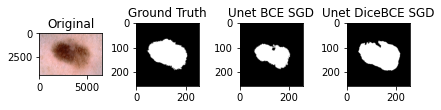

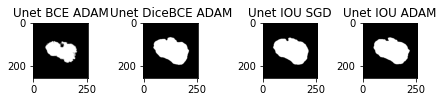

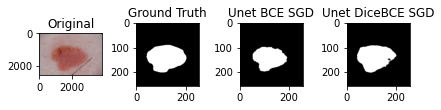

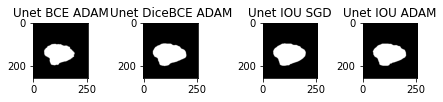

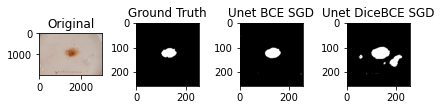

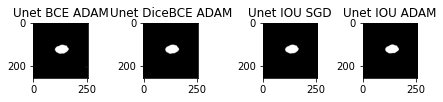

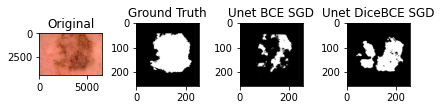

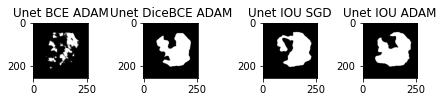

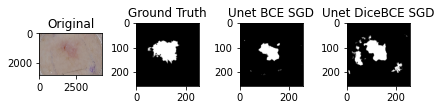

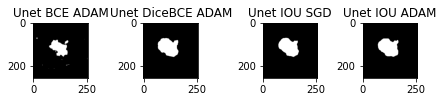

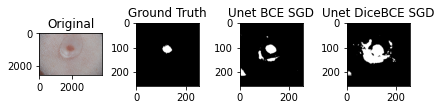

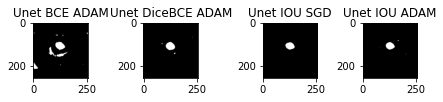

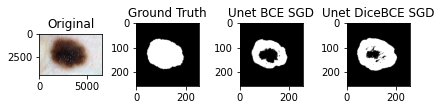

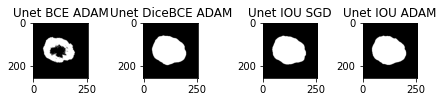

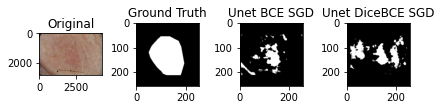

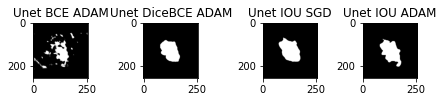

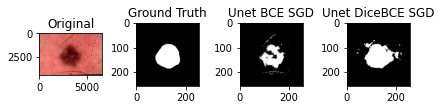

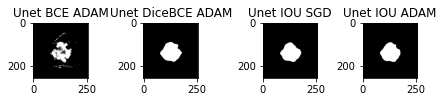

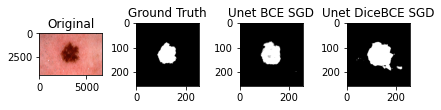

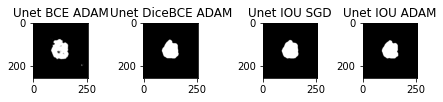

In [ ]:
df = pd.read_csv(test_csv_path)

samples = df.sample(n = 10)

for idx, row in samples.iterrows():

    img_id = '/' + row['image_id']

    img_path = Test_img_folder + img_id + '.jpg'
    mask_path = Test_seg_folder + img_id + '_segmentation.png'

    img = Image.open(img_path)
    mask = Image.open(mask_path).convert('1')

    image = img_transforms(img)
    mask = mask_transforms(mask)


    preds1 = predict(image, unet_bce_sgd, th_unet_bce_sgd)
    preds2 = predict(image, unet_dicebce_sgd, th_unet_dicebce_sgd)
    preds3 = predict(image, unet_bce_adam, th_unet_bce_adam)
    preds4 = predict(image, unet_dicebce_adam, th_unet_dicebce_adam)
    preds5 = predict(image, unet_iou_sgd, th_unet_iou_sgd)
    preds6 = predict(image, unet_iou_adam, th_unet_iou_adam)
    

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, constrained_layout = True)

    ax1.imshow(np.array(img))
    ax1.set_title('Original')
         
    ax2.imshow(np.array(mask)[0, :, :], cmap='gray')
    ax2.set_title('Ground Truth')

    ax3.imshow(preds1, cmap='gray')
    ax3.set_title('Unet BCE SGD')

    ax4.imshow(preds2, cmap='gray')
    ax4.set_title('Unet DiceBCE SGD')

    plt.show()

    fig, (ax5, ax6, ax7, ax8) = plt.subplots(1, 4, constrained_layout = True)
    
    ax5.imshow(preds3, cmap='gray')
    ax5.set_title('Unet BCE ADAM')

    ax6.imshow(preds4, cmap='gray')
    ax6.set_title('Unet DiceBCE ADAM')

    ax7.imshow(preds5, cmap='gray')
    ax7.set_title('Unet IOU SGD')

    ax8.imshow(preds6, cmap='gray')
    ax8.set_title('Unet IOU ADAM')   

    plt.show()

## ***Mask Generation for ML + Test on Original Resolution***

In [ ]:
in_data = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/TrainCls.csv')
out_mask = []

for idx, row in in_data.iterrows():

    img_id = '/' + row['image_id']

    img_path = Train_img_folder + img_id + '.jpg'
    mask_path = Train_seg_folder + img_id + '_segmentation.png'

    img = Image.open(img_path)
    mask = Image.open(mask_path).convert('1')

    image = img_transforms(img)
    mask = mask_transforms(mask)


    pred = predict(image, unet_dicebce_adam, th_unet_dicebce_adam)
    out_mask.append(pred)


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/unet_dice_bce_adam_masks_256.npy', 'wb') as f:
    np.save(f, out_mask)

In [ ]:
test_in_data = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/TestCls.csv')
test_out_mask = []

for idx, row in test_in_data.iterrows():

    img_id = '/' + row['image_id']

    img_path = Test_img_folder + img_id + '.jpg'
    mask_path = Test_seg_folder + img_id + '_segmentation.png'

    img = Image.open(img_path)
    mask = Image.open(mask_path).convert('1')

    image = img_transforms(img)
    mask = mask_transforms(mask)


    pred = predict(image, unet_dicebce_adam, th_unet_dicebce_adam)
    test_out_mask.append(pred)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/test_unet_dice_bce_adam_masks_256.npy', 'wb') as f:
    np.save(f, test_out_mask)

In [ ]:
val_in_data = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/ValCls.csv')
val_out_mask = []

for idx, row in val_in_data.iterrows():

    img_id = '/' + row['image_id']

    img_path = Val_img_folder + img_id + '.jpg'
    mask_path = Val_seg_folder + img_id + '_segmentation.png'

    img = Image.open(img_path)
    mask = Image.open(mask_path).convert('1')

    image = img_transforms(img)
    mask = mask_transforms(mask)


    pred = predict(image, unet_dicebce_adam, th_unet_dicebce_adam)
    val_out_mask.append(pred)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/val_unet_dice_bce_adam_masks_256.npy', 'wb') as f:
    np.save(f, val_out_mask)

In [ ]:
    # in_data = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/TestCls.csv')
    # # samples = in_data.sample(n = 1)
    # store_jac = []

    # for idx, row in samples.iterrows():

    # img_id = '/' + row['image_id']
    # # print(img_id)

    # img_path = Test_img_folder + img_id + '.jpg'
    # mask_path = Test_seg_folder + img_id + '_segmentation.png'

    # img = Image.open(img_path)
    # mask = Image.open(mask_path)
    # gt = mask.copy()
    # mask=mask.convert('1')
    # # print(gt.size)


    # mask_sizeX, mask_sizeY = gt.size
    # rev_size = max(mask_sizeX, mask_sizeY)
    # image = img_transforms(img)
    # mask = mask_transforms(mask)

    # th_unet_dicebce_adam =0.3283
    # pred = predict(image, unet_dicebce_adam, th_unet_dicebce_adam)
    # pred[pred>=th_unet_dicebce_adam]=255
    # pred[pred<th_unet_dicebce_adam]=0


    # resized_pred = cv.resize(pred, dsize=(rev_size, rev_size), interpolation = cv.INTER_NEAREST)

    # crop_img = resized_pred[(int((rev_size - mask_sizeY) / 2)):(int((rev_size - mask_sizeY) / 2))+mask_sizeY,(int((rev_size - mask_sizeX) / 2)):(int((rev_size - mask_sizeX) / 2))+mask_sizeX]

    # open_cv_image = np.array(gt) 
    # cv2_imshow(open_cv_image)
    # # print(crop_img.shape)
    # cv2_imshow(crop_img)



    # jac = jaccard2(crop_img,gt)
    # store_jac.append(jac)

    # avg_jac = np.mean(store_jac)
    # print(avg_jac)